# Jake Mitchell initial analysis

### Notes
 
    The following codebook summarizes each variable:
1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
J
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
J
    - Could make XY graph and use fire intensity as heat
    - Made XY count heat map
    - Northern park has had very few fires
3. month - month of the year: “jan” to “dec”
R
    - will need to numerically encode this
4. day - day of the week: “mon” to “sun”
R
    - may need to numerically encode this, likely has no effect.  Could based on cause of fire (campfires on weekends
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
J
    - Fine Fuel Moisture Code
    - Heavy Left Skew, may want to try log of it
6. DMC - DMC index from the FWI system: 1.1 to 291.3
J
    - Duff Moisture Code
    - Seems to be fairly normally distributed, with a slight lew skew and bimodal tendency around 40 and 120
7. DC - DC index from the FWI system: 7.9 to 860.6
J
    - Drought Code
    - Heavily bimodal, ~50 and ~650, slight left skew
8. ISI - ISI index from the FWI system: 0.0 to 56.10
?
    - Initial Spread Index
    - Normally distributed with an extreme outlier
9. temp - temperature in Celsius degrees: 2.2 to 33.30
J
    - Seems very normally distributed, should behave well
10. RH - relative humidity in %: 15.0 to 100
R
    - Slight left skew but nothing too bad
11. wind - wind speed in km/h: 0.40 to 9.40
R
    - Fairly well balanced, slight right skew as expected (super high winds are very uncommon)
12. rain - outside rain in mm/m2 : 0.0 to 6.4
R
    - Rain is almost always at 0, with one or two extreme outliers.  This may be a good indication that a fire will be small.  This could be worth looking into those few points with rain.  This makes sense because in order for there to be a data point a fire had to be detected, and rain would put it out.
13. area - the burned area of the forest (in hectares): 0.00 to 1090.84
B
    - Heavily right skewed as I talk about below.  The big fires are definitely outliers.
14. logArea - A log version of area
    - Normally distributed, and 0 centered.

- Area is the proxy for how damaging a fire is
    - We may want to look at the log of area since it is so right skewed
        - logArea seems to be very well distributed
    - There are a lot of fires with 0 area, which causes -inf when logging them
    - We have 247 fires with an area of 0, 47%, almost half
    
- We have 517 rows

- Corellation non 0:
    - Everything has very low correlation with area
        - log area has slightly better correlations with things
    - Top correlation scores are:
        - DMC FFMC 0.48
        - ISI FFMC = 0.704
        - tmp FFMC = 0.562
        - DC DMC 0.669
        - temp DMC 0.502
        - temp DC 0.496
        - temp ISI 0.466
        - RH temp -0.498
    - Top Area Corellation scores 
        - DMC 0.0891
        - FFMC 0.0543
        - DC 0.0467
    - Top logArea Corellation scores
        - ISI -0.11
        - wind 0.0547
        - RH 0.0497
        - 

- Corelation with all data:
    - Still low corellation with area
    - Top Area corellation scores
        - 


In [2]:
library(dplyr)
library(ggplot2)
library(GGally)
library(ggcorrplot)
library(ggpubr)
require(gridExtra)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'GGally'

The following object is masked from 'package:dplyr':

    nasa

Loading required package: magrittr
Loading required package: gridExtra

Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



In [3]:
ff = read.csv("forestfires.csv")


#feature engineering
ff$logArea = log(ff$area)
numff = Filter(is.numeric, ff)
bigff = ff[ff$area>1,]

head(ff)

X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,logArea
7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0,-Inf
7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0,-Inf
7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0,-Inf
8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0,-Inf
8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0,-Inf
8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0,-Inf


In [4]:
summary(ff)

       X               Y           month      day          FFMC      
 Min.   :1.000   Min.   :2.0   aug    :184   fri:85   Min.   :18.70  
 1st Qu.:3.000   1st Qu.:4.0   sep    :172   mon:74   1st Qu.:90.20  
 Median :4.000   Median :4.0   mar    : 54   sat:84   Median :91.60  
 Mean   :4.669   Mean   :4.3   jul    : 32   sun:95   Mean   :90.64  
 3rd Qu.:7.000   3rd Qu.:5.0   feb    : 20   thu:61   3rd Qu.:92.90  
 Max.   :9.000   Max.   :9.0   jun    : 17   tue:64   Max.   :96.20  
                               (Other): 38   wed:54                  
      DMC              DC             ISI              temp      
 Min.   :  1.1   Min.   :  7.9   Min.   : 0.000   Min.   : 2.20  
 1st Qu.: 68.6   1st Qu.:437.7   1st Qu.: 6.500   1st Qu.:15.50  
 Median :108.3   Median :664.2   Median : 8.400   Median :19.30  
 Mean   :110.9   Mean   :547.9   Mean   : 9.022   Mean   :18.89  
 3rd Qu.:142.4   3rd Qu.:713.9   3rd Qu.:10.800   3rd Qu.:22.80  
 Max.   :291.3   Max.   :860.6   Max.   :56.

## Working on Area manipulation

In [6]:
"Number of records"
nrow(ff)
"Number of 0 area records"
nrow(ff[ff$area == 0,])
"ratio"
nrow(ff[ff$area == 0,])/nrow(ff)

[1] "Number of records"

[1] 517

[1] "Number of 0 area records"

[1] 247

[1] "ratio"

[1] 0.4777563

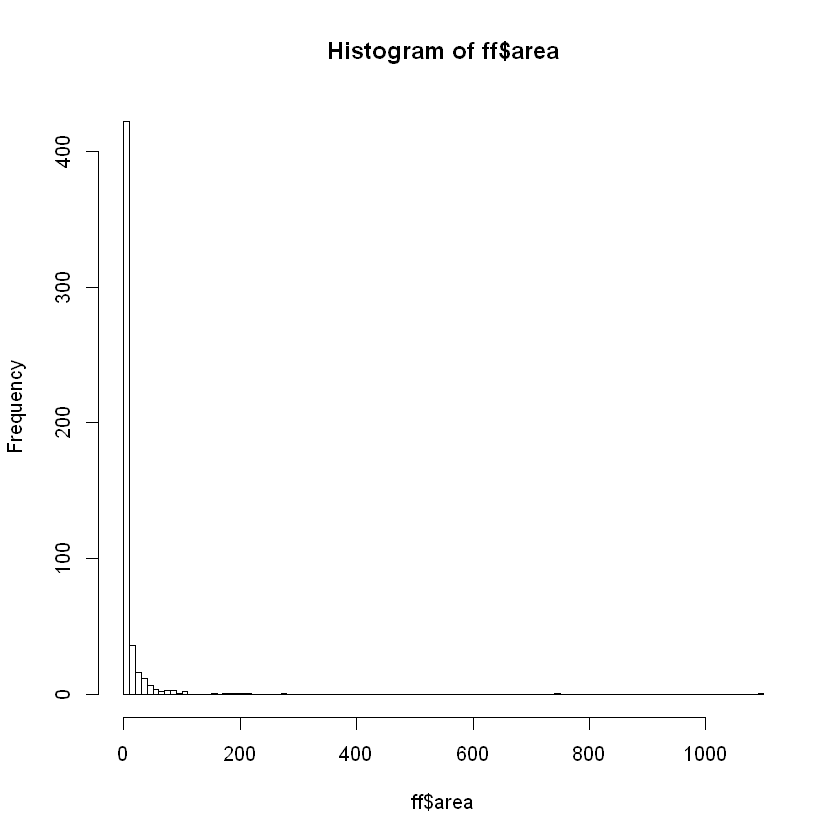

In [7]:
hist(ff$area, breaks=100)

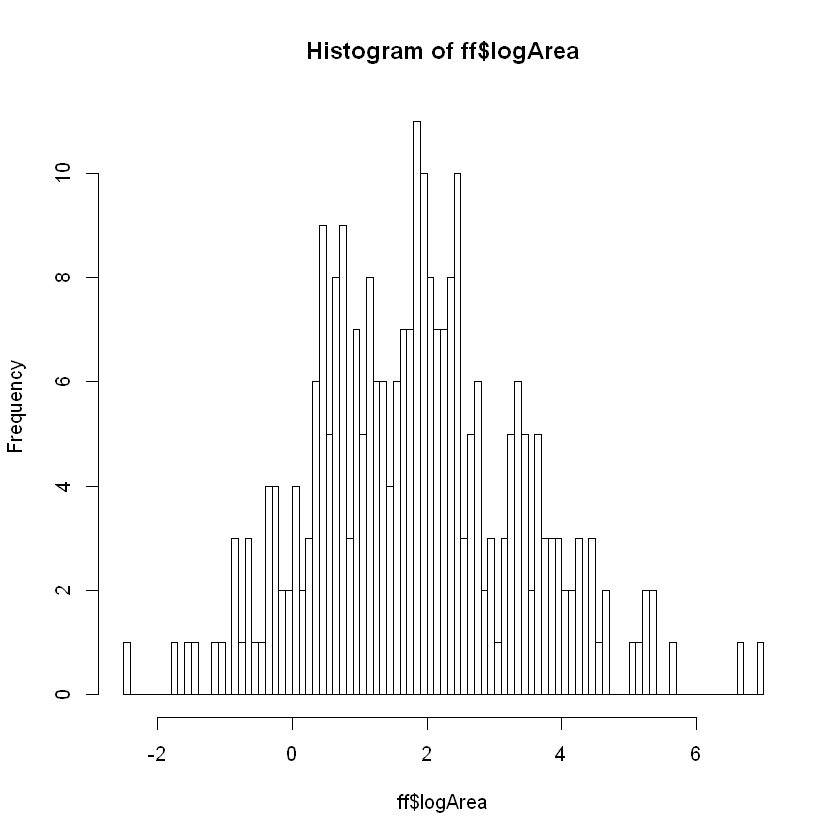

In [8]:
hist(ff$logArea, breaks=100)

In [9]:
"Largest Fires"
ff[order(ff$logArea, decreasing=T)[1:10],]

[1] "Largest Fires"

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,logArea
239,6,5,sep,sat,92.5,121.1,674.4,8.6,25.1,27,4.0,0,1090.84,6.994703
416,8,6,aug,thu,94.8,222.4,698.6,13.9,27.5,27,4.9,0,746.28,6.615101
480,7,4,jul,mon,89.2,103.9,431.6,6.4,22.6,57,4.9,0,278.53,5.629526
238,1,2,sep,tue,91.0,129.5,692.6,7.0,18.8,40,2.2,0,212.88,5.360729
237,2,2,sep,sat,92.5,121.1,674.4,8.6,18.2,46,1.8,0,200.94,5.303006
236,8,6,aug,sun,91.4,142.4,601.4,10.6,19.6,41,5.8,0,196.48,5.280561
421,8,8,aug,wed,91.7,191.4,635.9,7.8,26.2,36,4.5,0,185.76,5.224456
378,2,2,aug,sat,93.7,231.1,715.1,8.4,21.9,42,2.2,0,174.63,5.162669
235,4,5,sep,sat,92.5,121.1,674.4,8.6,17.7,25,3.1,0,154.88,5.042651
234,9,4,sep,tue,84.4,73.4,671.9,3.2,24.3,36,3.1,0,105.66,4.660226


In [10]:
"Smallest fires"
ff[order(ff$logArea)[1:10],]

[1] "Smallest fires"

X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,logArea
7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0,-Inf
7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0,-Inf
7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0,-Inf
8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0,-Inf
8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0,-Inf
8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0,-Inf
8,6,aug,mon,92.3,88.9,495.6,8.5,24.1,27,3.1,0.0,0,-Inf
8,6,aug,mon,91.5,145.4,608.2,10.7,8.0,86,2.2,0.0,0,-Inf
8,6,sep,tue,91.0,129.5,692.6,7.0,13.1,63,5.4,0.0,0,-Inf
7,5,sep,sat,92.5,88.0,698.6,7.1,22.8,40,4.0,0.0,0,-Inf


In [11]:
nrow(ff[ff$area != 0,])
numffnon0 = Filter(is.numeric, ff[ff$area != 0,])

[1] 270

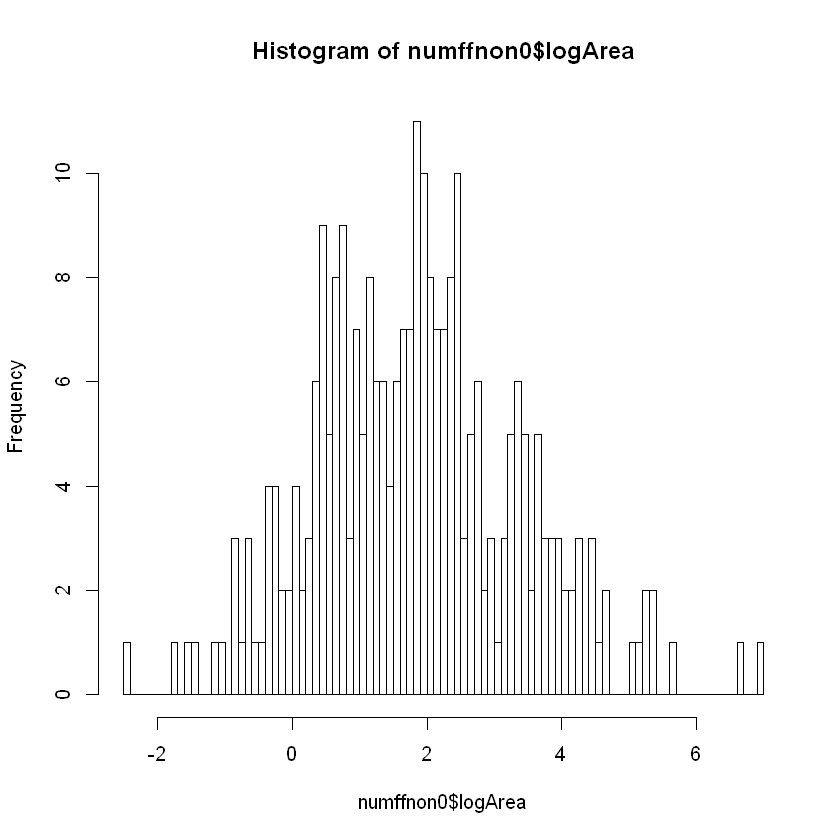

In [26]:
hist(numffnon0$logArea, breaks=100)

### Correlation matrix of all non 0 data

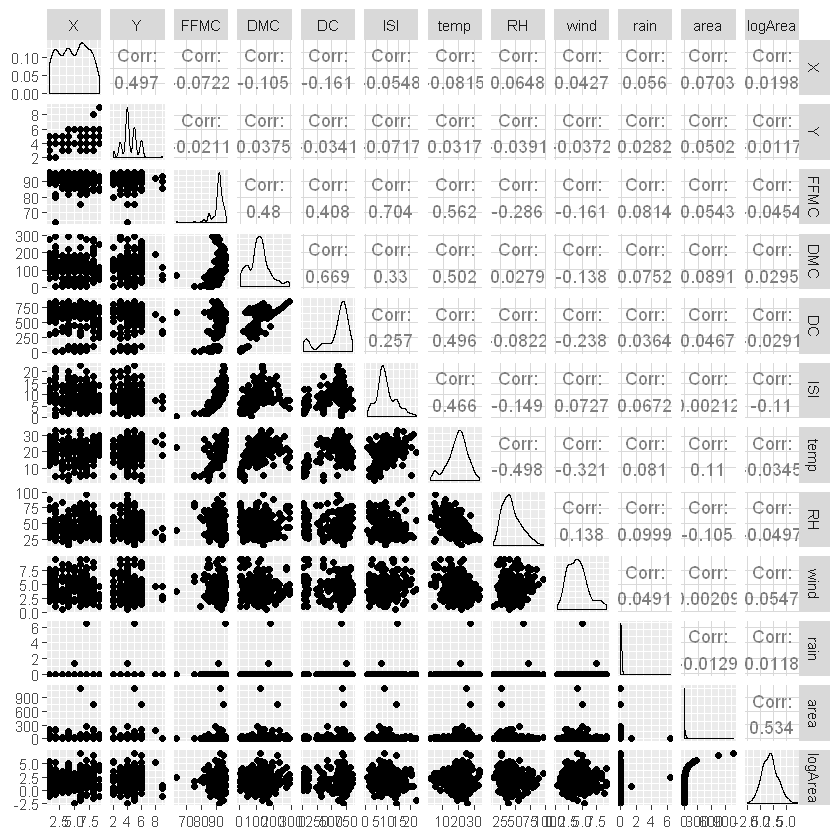

In [13]:
ggpairs(numffnon0)

In [15]:
summary(numffnon0)

       X               Y              FFMC            DMC       
 Min.   :1.000   Min.   :2.000   Min.   :63.50   Min.   :  3.2  
 1st Qu.:3.000   1st Qu.:4.000   1st Qu.:90.33   1st Qu.: 82.9  
 Median :5.000   Median :4.000   Median :91.70   Median :111.7  
 Mean   :4.807   Mean   :4.367   Mean   :91.03   Mean   :114.7  
 3rd Qu.:7.000   3rd Qu.:5.000   3rd Qu.:92.97   3rd Qu.:141.3  
 Max.   :9.000   Max.   :9.000   Max.   :96.20   Max.   :291.3  
       DC             ISI              temp             RH       
 Min.   : 15.3   Min.   : 0.800   Min.   : 2.20   Min.   :15.00  
 1st Qu.:486.5   1st Qu.: 6.800   1st Qu.:16.12   1st Qu.:33.00  
 Median :665.6   Median : 8.400   Median :20.10   Median :41.00  
 Mean   :570.9   Mean   : 9.177   Mean   :19.31   Mean   :43.73  
 3rd Qu.:721.3   3rd Qu.:11.375   3rd Qu.:23.40   3rd Qu.:53.00  
 Max.   :860.6   Max.   :22.700   Max.   :33.30   Max.   :96.00  
      wind            rain              area            logArea       
 Min.   :0.4

In [16]:
numffnon0[order(numffnon0$logArea)[1:10],]

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,logArea
247,5,4,91.8,175.1,700.7,13.8,25.7,39,5.4,0,0.09,-2.4079456
267,6,5,94.3,131.7,607.1,22.7,19.4,55,4.0,0,0.17,-1.7719568
253,6,5,93.1,157.3,666.7,13.5,22.1,37,3.6,0,0.21,-1.5606477
252,8,5,93.1,157.3,666.7,13.5,24.0,36,3.1,0,0.24,-1.4271164
440,1,3,91.1,91.3,738.1,7.2,19.1,46,2.2,0,0.33,-1.1086626
139,9,9,85.8,48.3,313.4,3.9,18.0,42,2.7,0,0.36,-1.0216512
307,7,4,89.6,84.1,714.3,5.7,17.1,53,5.4,0,0.41,-0.8915981
140,1,4,91.0,129.5,692.6,7.0,21.7,38,2.2,0,0.43,-0.8439701
511,6,5,91.0,166.9,752.6,7.1,18.2,62,5.4,0,0.43,-0.8439701
141,2,5,90.9,126.5,686.5,7.0,21.9,39,1.8,0,0.47,-0.7550226


I am trying to find a good way to convert the 0 area fires into a useful log value.  I am thinking about marking them as -5 and seeing what happens.  I will store this df in a new dataframe so I don't mess anything else up.

In [17]:
nffadj = numff
summary(nffadj)
nffadj$logArea[nffadj$logArea==-Inf] <- -5
summary(nffadj)

       X               Y            FFMC            DMC              DC       
 Min.   :1.000   Min.   :2.0   Min.   :18.70   Min.   :  1.1   Min.   :  7.9  
 1st Qu.:3.000   1st Qu.:4.0   1st Qu.:90.20   1st Qu.: 68.6   1st Qu.:437.7  
 Median :4.000   Median :4.0   Median :91.60   Median :108.3   Median :664.2  
 Mean   :4.669   Mean   :4.3   Mean   :90.64   Mean   :110.9   Mean   :547.9  
 3rd Qu.:7.000   3rd Qu.:5.0   3rd Qu.:92.90   3rd Qu.:142.4   3rd Qu.:713.9  
 Max.   :9.000   Max.   :9.0   Max.   :96.20   Max.   :291.3   Max.   :860.6  
      ISI              temp             RH              wind      
 Min.   : 0.000   Min.   : 2.20   Min.   : 15.00   Min.   :0.400  
 1st Qu.: 6.500   1st Qu.:15.50   1st Qu.: 33.00   1st Qu.:2.700  
 Median : 8.400   Median :19.30   Median : 42.00   Median :4.000  
 Mean   : 9.022   Mean   :18.89   Mean   : 44.29   Mean   :4.018  
 3rd Qu.:10.800   3rd Qu.:22.80   3rd Qu.: 53.00   3rd Qu.:4.900  
 Max.   :56.100   Max.   :33.30   Max.   :100

       X               Y            FFMC            DMC              DC       
 Min.   :1.000   Min.   :2.0   Min.   :18.70   Min.   :  1.1   Min.   :  7.9  
 1st Qu.:3.000   1st Qu.:4.0   1st Qu.:90.20   1st Qu.: 68.6   1st Qu.:437.7  
 Median :4.000   Median :4.0   Median :91.60   Median :108.3   Median :664.2  
 Mean   :4.669   Mean   :4.3   Mean   :90.64   Mean   :110.9   Mean   :547.9  
 3rd Qu.:7.000   3rd Qu.:5.0   3rd Qu.:92.90   3rd Qu.:142.4   3rd Qu.:713.9  
 Max.   :9.000   Max.   :9.0   Max.   :96.20   Max.   :291.3   Max.   :860.6  
      ISI              temp             RH              wind      
 Min.   : 0.000   Min.   : 2.20   Min.   : 15.00   Min.   :0.400  
 1st Qu.: 6.500   1st Qu.:15.50   1st Qu.: 33.00   1st Qu.:2.700  
 Median : 8.400   Median :19.30   Median : 42.00   Median :4.000  
 Mean   : 9.022   Mean   :18.89   Mean   : 44.29   Mean   :4.018  
 3rd Qu.:10.800   3rd Qu.:22.80   3rd Qu.: 53.00   3rd Qu.:4.900  
 Max.   :56.100   Max.   :33.30   Max.   :100

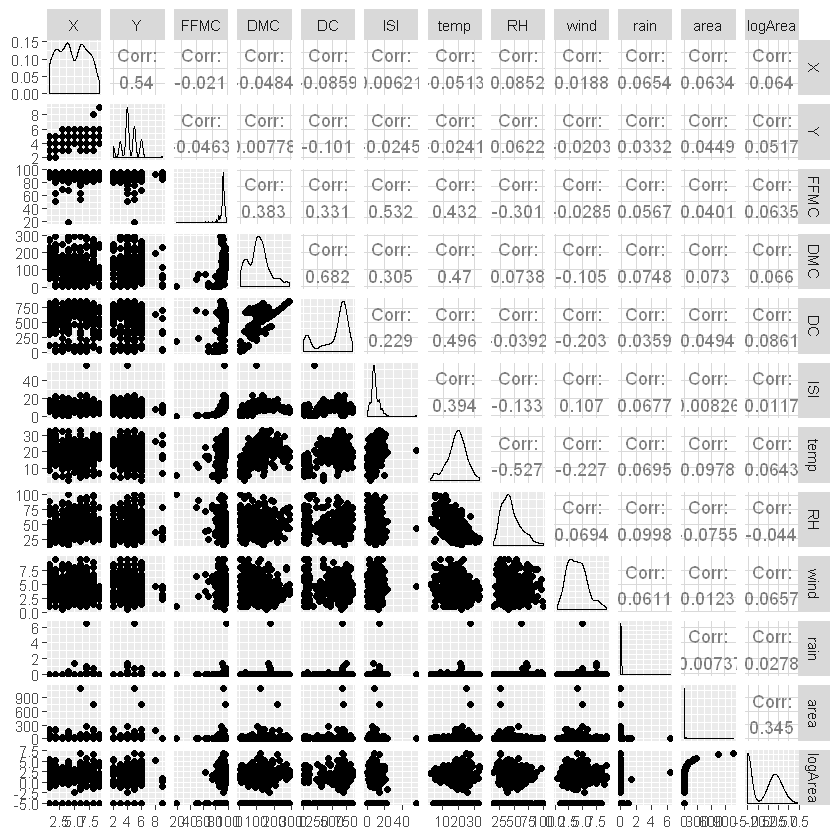

In [18]:
ggpairs(nffadj)

In [1]:
for (name in names(numff)){
    ggplot(numff[name], breaks=100)
}

ERROR: Error in eval(expr, envir, enclos): object 'numff' not found


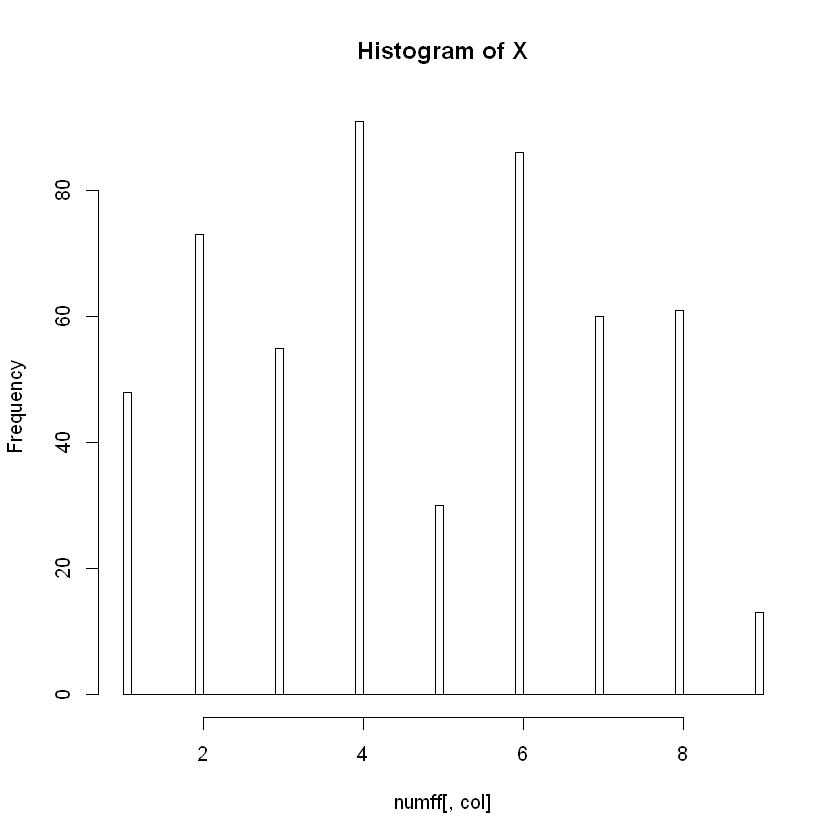

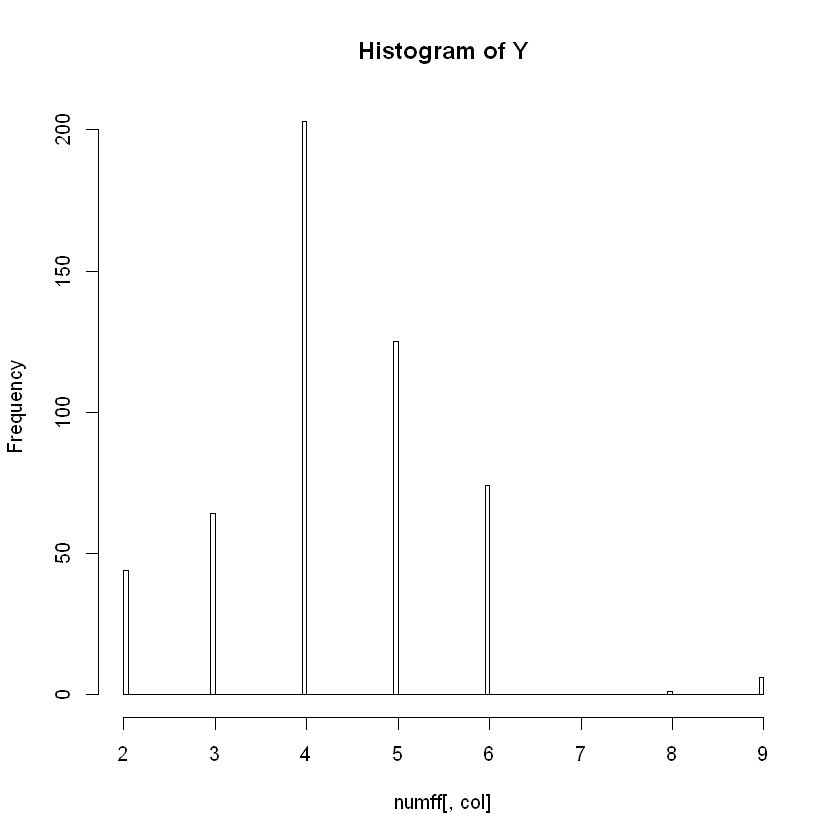

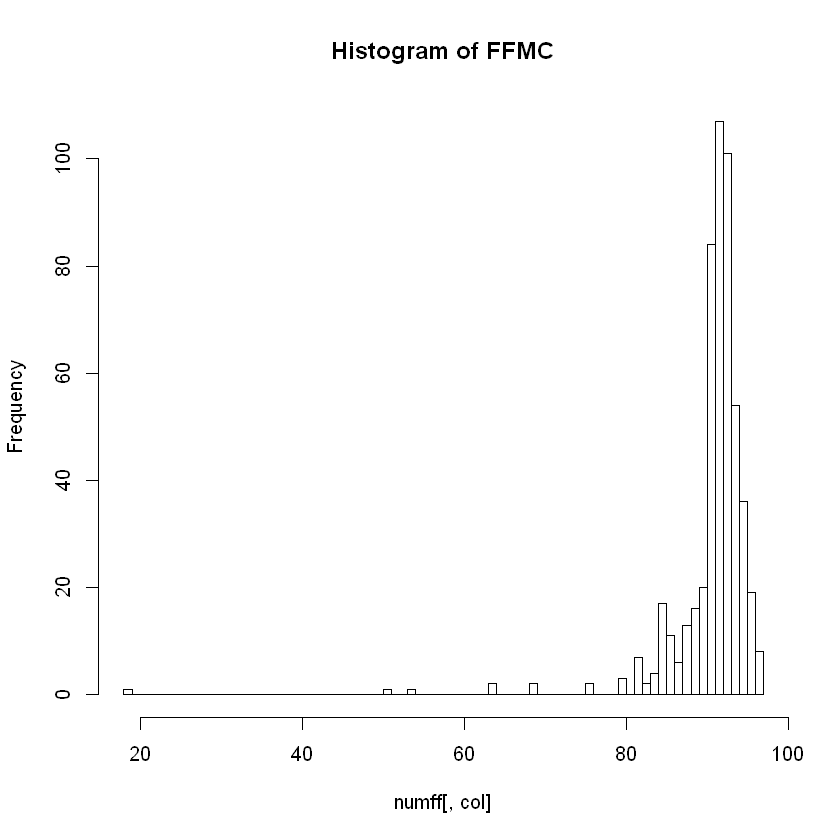

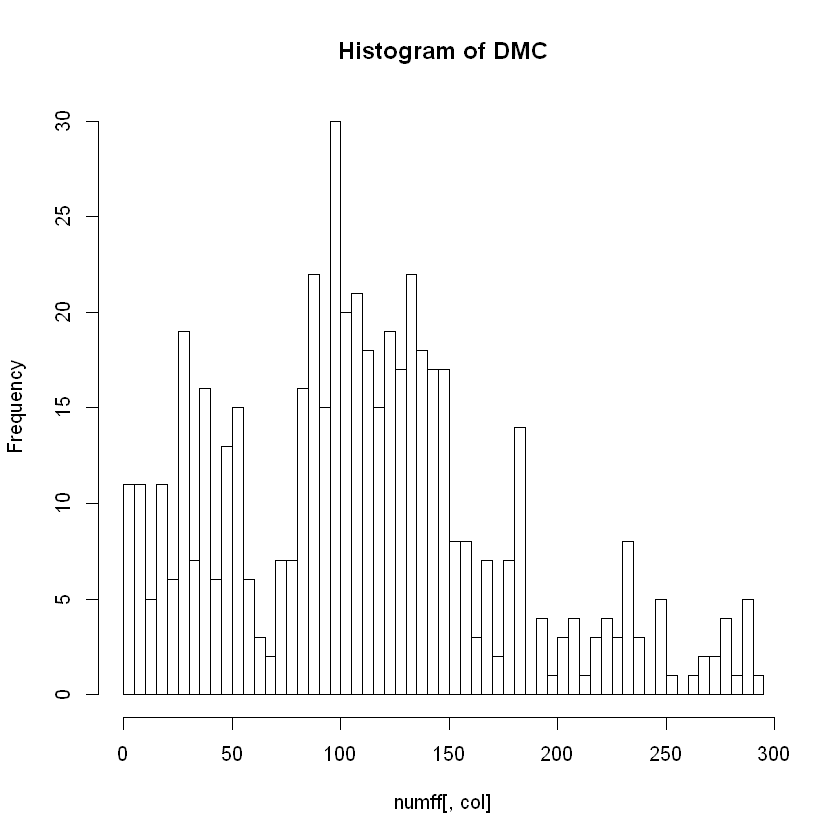

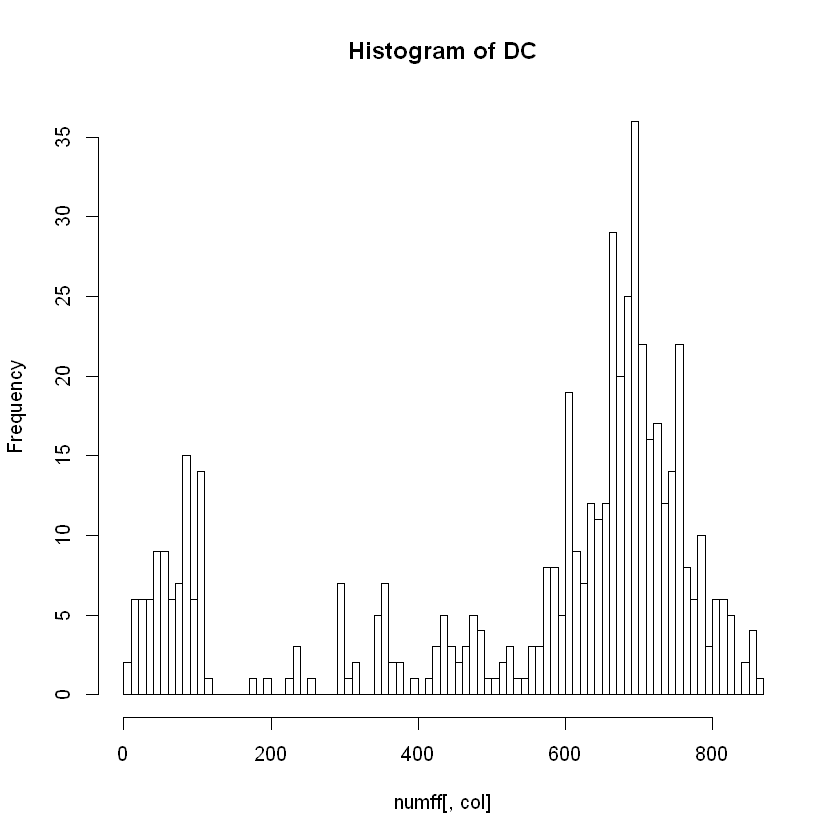

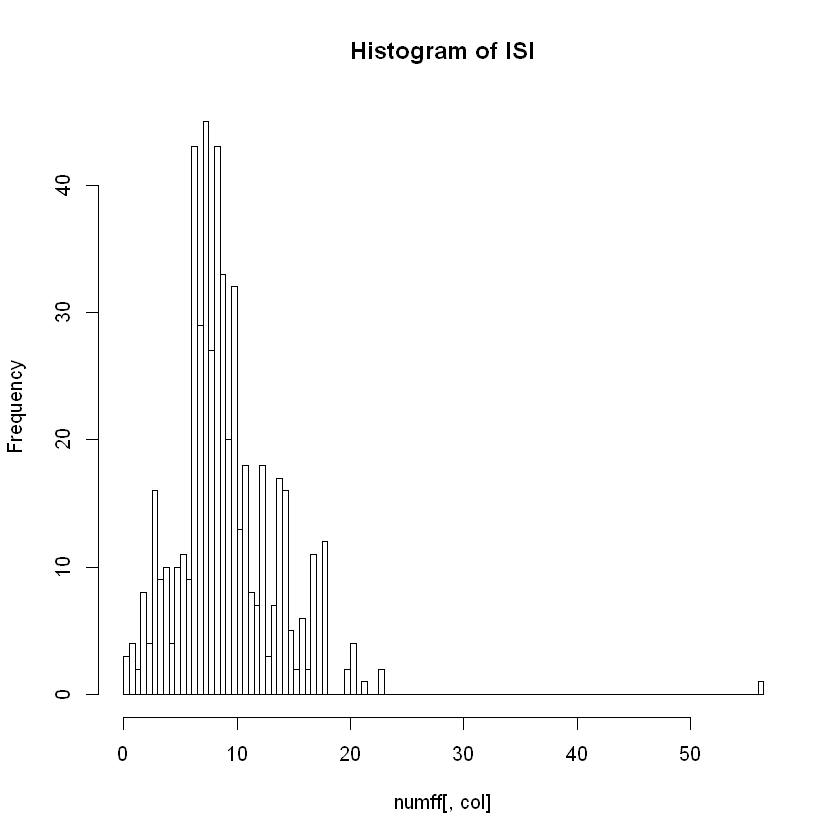

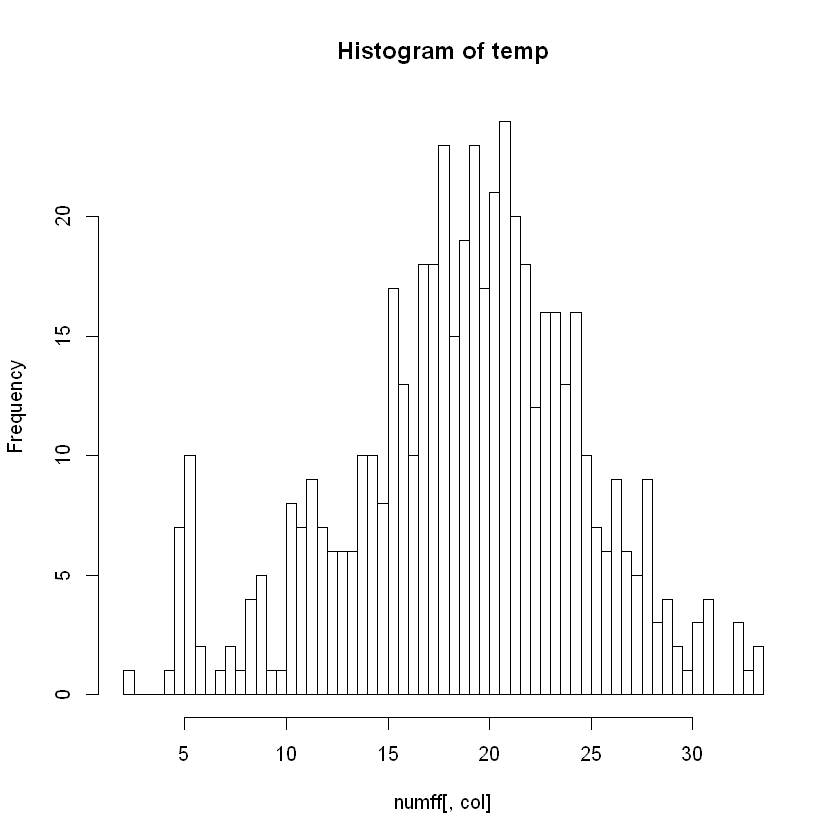

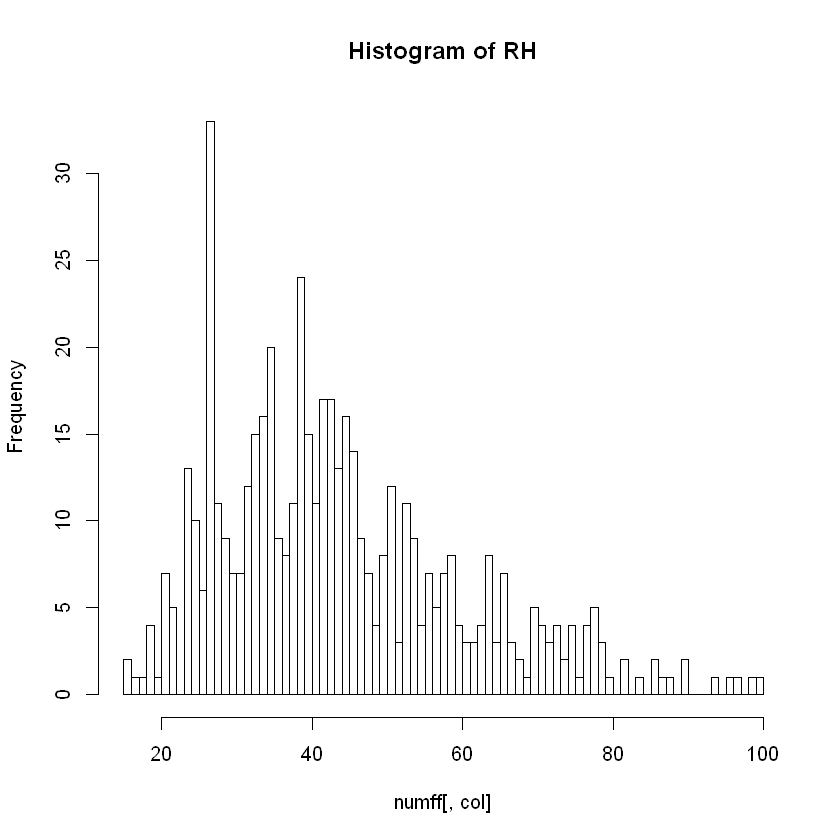

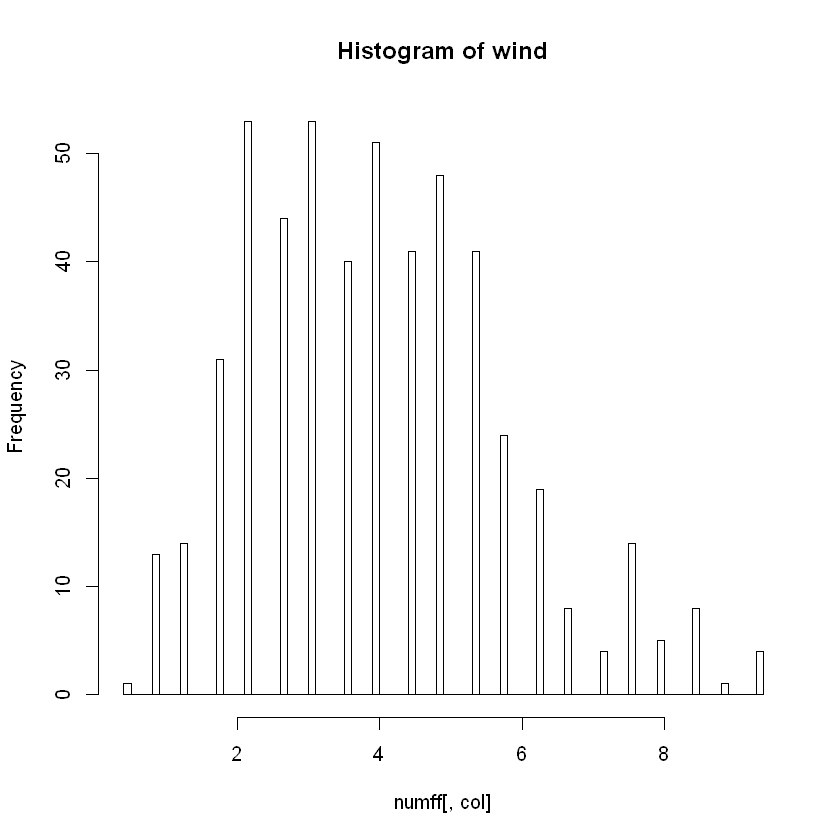

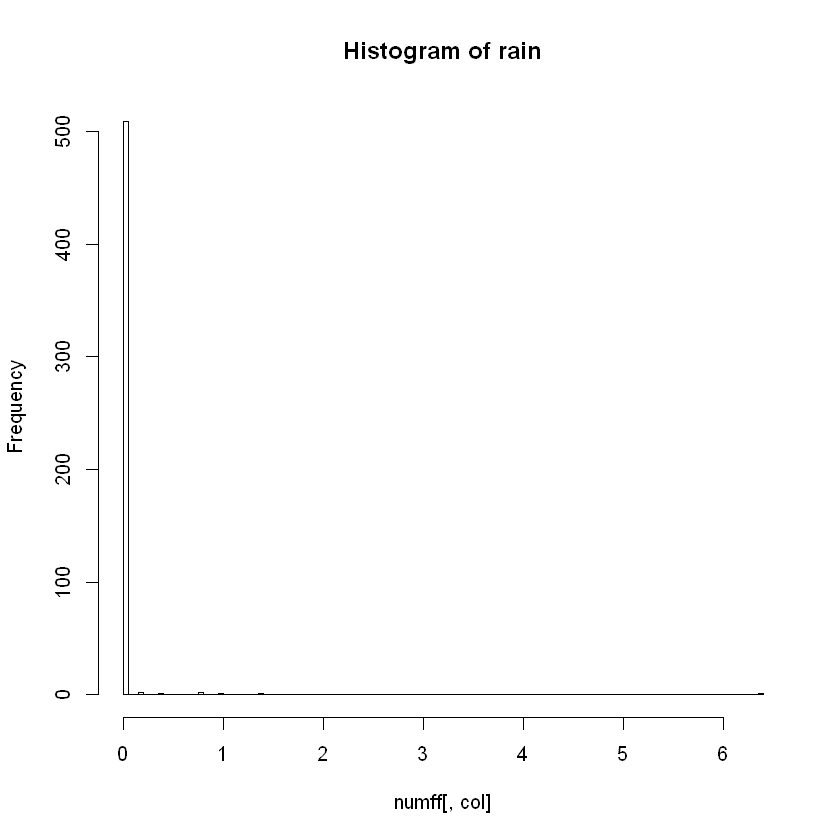

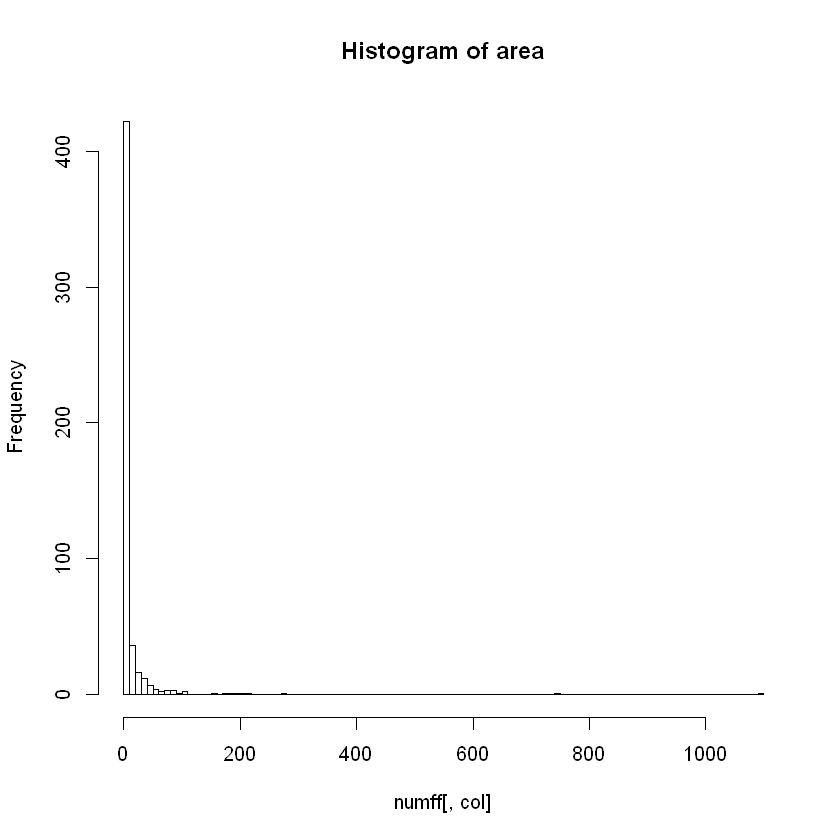

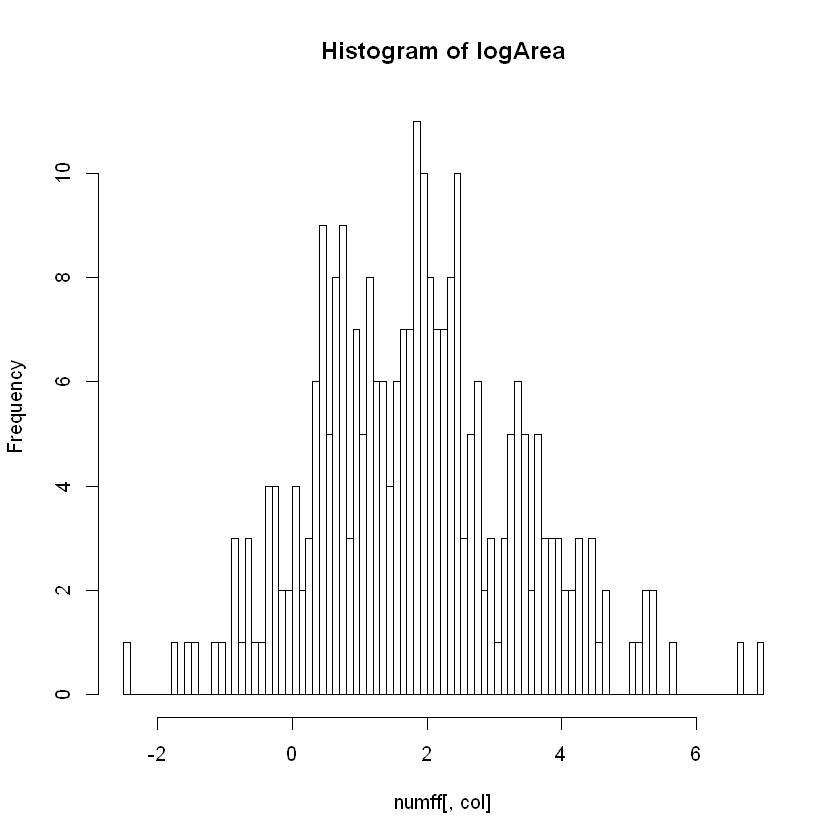

In [21]:
for (col in 1:ncol(numff)) {
    hist(numff[,col], breaks=100, main = paste("Histogram of",colnames(numff)[col]) )
}

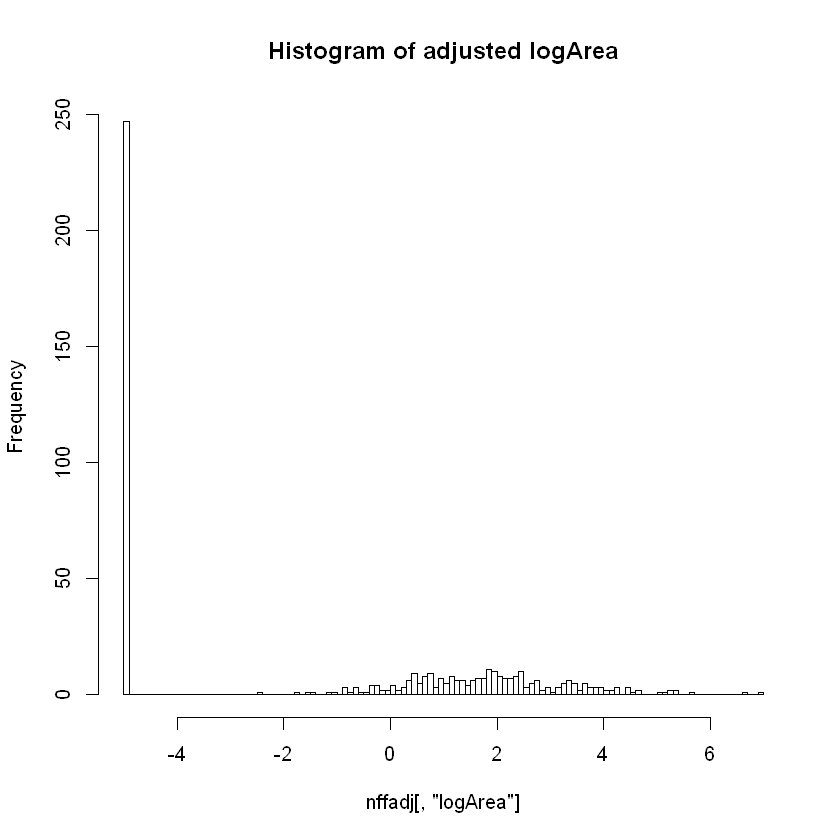

In [22]:
hist(nffadj[,'logArea'], breaks=100, main = "Histogram of adjusted logArea" )

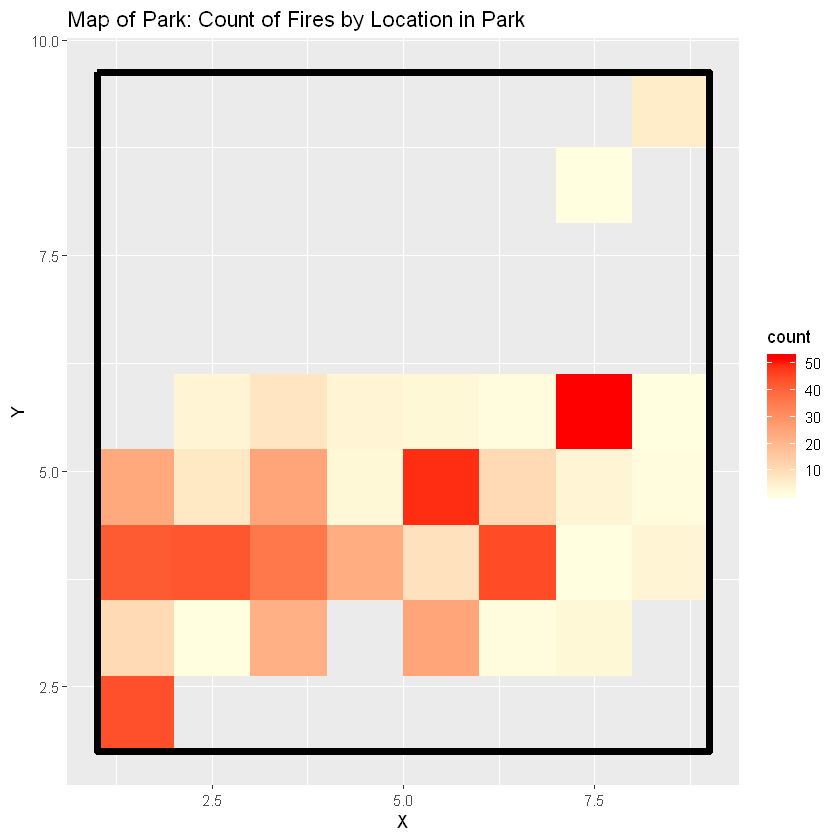

In [140]:
ggplot(ff, aes(x=X, y=Y)) + 
  geom_bin2d(bins=8) + 
  scale_fill_gradient(low= "light yellow", high="Red") +
  geom_rect(xmin=1, xmax=9, ymin=1.75, ymax=9.625, color="black", fill=NA, size=2) +
  ggtitle("Map of Park: Count of Fires by Location in Park")

I think this one is the best representation so far

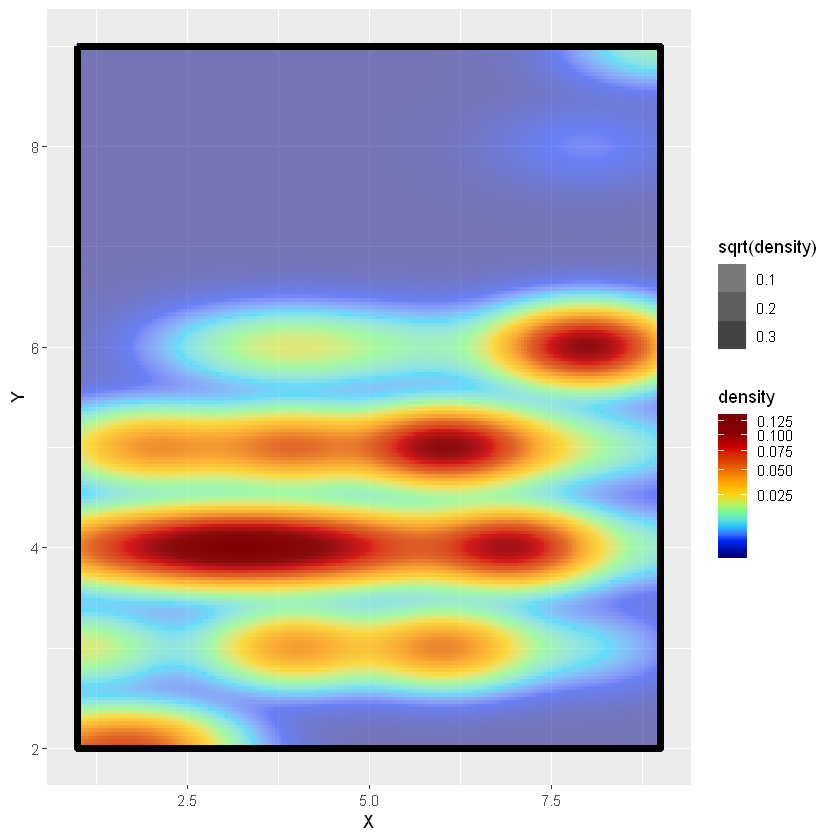

In [200]:
jet.colors <- colorRampPalette(c("#00007F", "blue", "#007FFF", "cyan", "#7FFF7F", "yellow", "#FF7F00", "orange", "#dd4b02", "red", "#7F0000", "dark red", "#7F0000"))

ggplot(ff, aes(X, Y)) + 
  stat_density2d(geom="tile", aes(fill=..density.., alpha=sqrt(..density..)), contour=FALSE, n=200) + 
  scale_alpha(range = c(0.5, 1.0)) + 
  scale_fill_gradientn(colours = jet.colors(10), trans="sqrt") + 
  geom_rect(xmin=1, xmax=9, ymin=2, ymax=9, color="black", fill=NA, size=2)

In [5]:
ffXYgroup = ff %>%
    group_by(X, Y) %>%
    summarize(logMeanArea = log(mean(area)), meanArea = mean(area), medianArea = median(area), count = length(area), totalArea = sum(area), maxArea = max(area))

In [6]:
names(ffXYgroup)

[1] "X"           "Y"           "logMeanArea" "meanArea"    "medianArea" 
[6] "count"       "totalArea"   "maxArea"

In [7]:
ffXYgroup[ffXYgroup==-Inf] <- 0
ffXYgroup

X,Y,logMeanArea,meanArea,medianArea,count,totalArea,maxArea
1,2,2.4489158,11.5757895,0.000,19,219.94,212.88
1,3,2.7545520,15.7140000,3.025,10,157.14,70.76
1,4,2.3044500,10.0186667,3.500,15,150.28,82.75
1,5,3.3627164,28.8675000,9.415,4,115.47,95.18
2,2,2.9180950,18.5060000,0.000,25,462.65,200.94
2,3,0.0000000,0.0000000,0.000,1,0.00,0.00
2,4,1.6695918,5.3100000,1.640,27,143.37,54.29
2,5,1.5328808,4.6315000,3.140,20,92.63,26.43
3,3,1.8840347,6.5800000,6.580,1,6.58,6.58
3,4,1.0778557,2.9383721,0.000,43,126.35,35.88


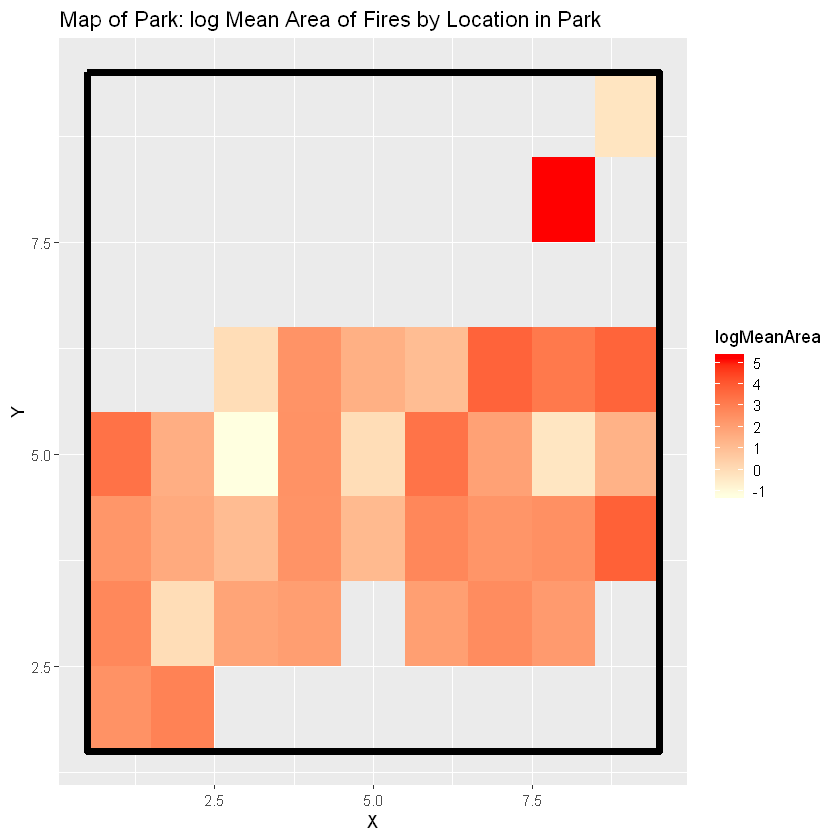

In [216]:
ggplot(ffXYgroup, aes(x=X, y=Y, fill=logMeanArea)) +
  geom_tile() + 
  scale_fill_gradient(low= "light yellow", high="Red") + 
  geom_rect(xmin=0.5, xmax=9.5, ymin=1.5, ymax=9.5, color="black", fill=NA, size=2) +
  ggtitle("Map of Park: log Mean Area of Fires by Location in Park")

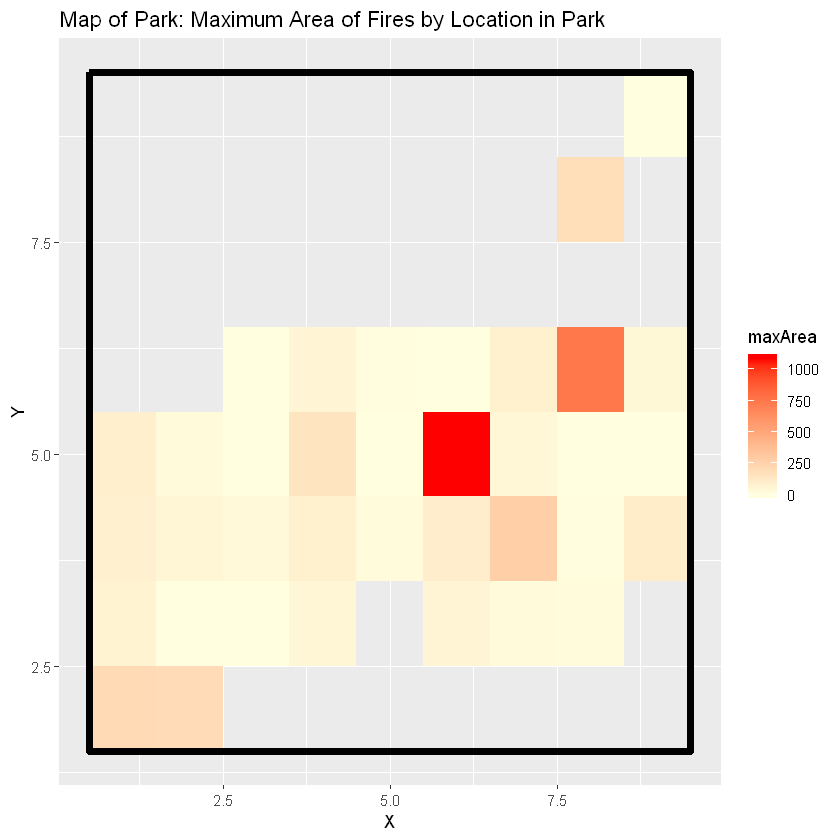

In [8]:
ggplot(ffXYgroup, aes(x=X, y=Y, fill=maxArea)) +
  geom_tile() + 
  scale_fill_gradient(low= "light yellow", high="Red") + 
  geom_rect(xmin=0.5, xmax=9.5, ymin=1.5, ymax=9.5, color="black", fill=NA, size=2) +
  ggtitle("Map of Park: Maximum Area of Fires by Location in Park")

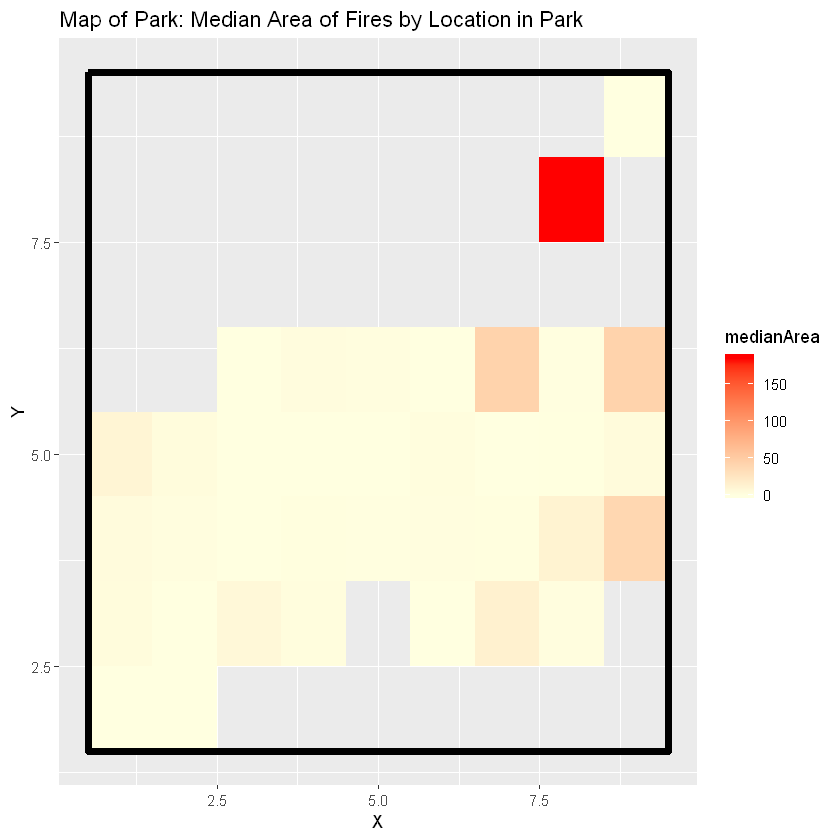

In [218]:
ggplot(ffXYgroup, aes(x=X, y=Y, fill=medianArea)) +
  geom_tile() + 
  scale_fill_gradient(low= "light yellow", high="Red") + 
  geom_rect(xmin=0.5, xmax=9.5, ymin=1.5, ymax=9.5, color="black", fill=NA, size=2) +
  ggtitle("Map of Park: Median Area of Fires by Location in Park")

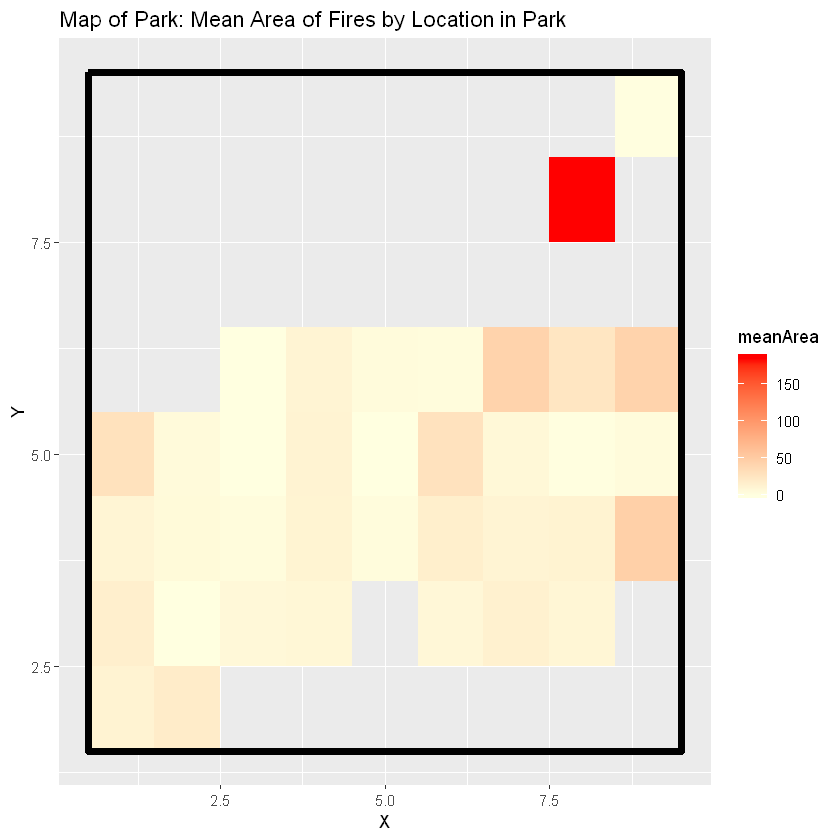

In [219]:
ggplot(ffXYgroup, aes(x=X, y=Y, fill=meanArea)) +
  geom_tile() + 
  scale_fill_gradient(low= "light yellow", high="Red") + 
  geom_rect(xmin=0.5, xmax=9.5, ymin=1.5, ymax=9.5, color="black", fill=NA, size=2) +
  ggtitle("Map of Park: Mean Area of Fires by Location in Park")

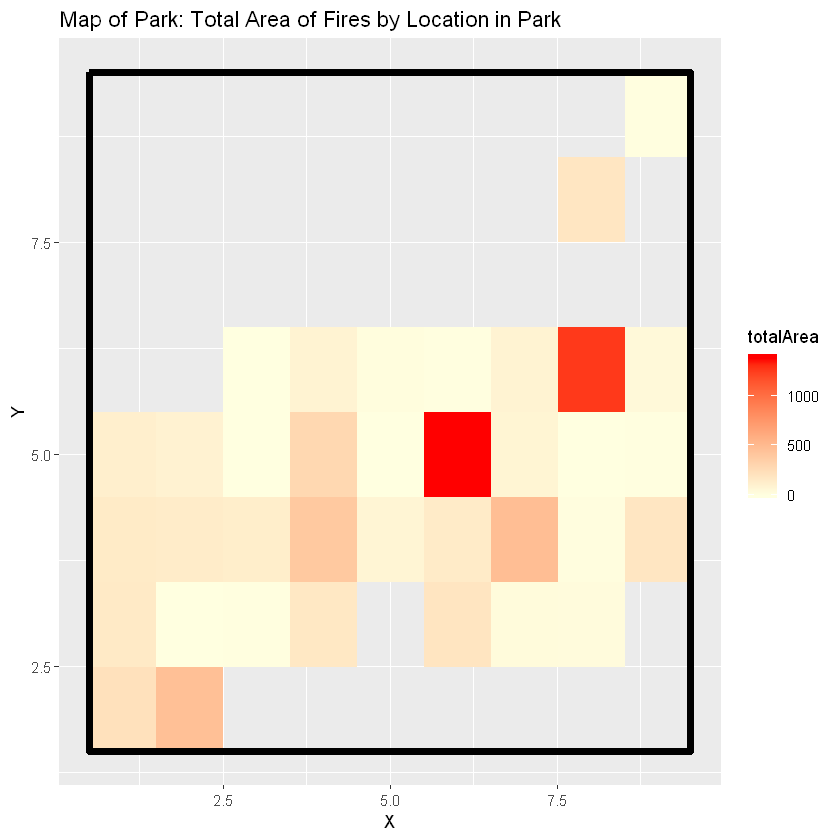

In [349]:
ggplot(ffXYgroup, aes(x=X, y=Y, fill=totalArea)) +
  geom_raster() + 
  scale_fill_gradient(low= "light yellow", high="Red") + 
  geom_rect(xmin=0.5, xmax=9.5, ymin=1.5, ymax=9.5, color="black", fill=NA, size=2) +
  ggtitle("Map of Park: Total Area of Fires by Location in Park")

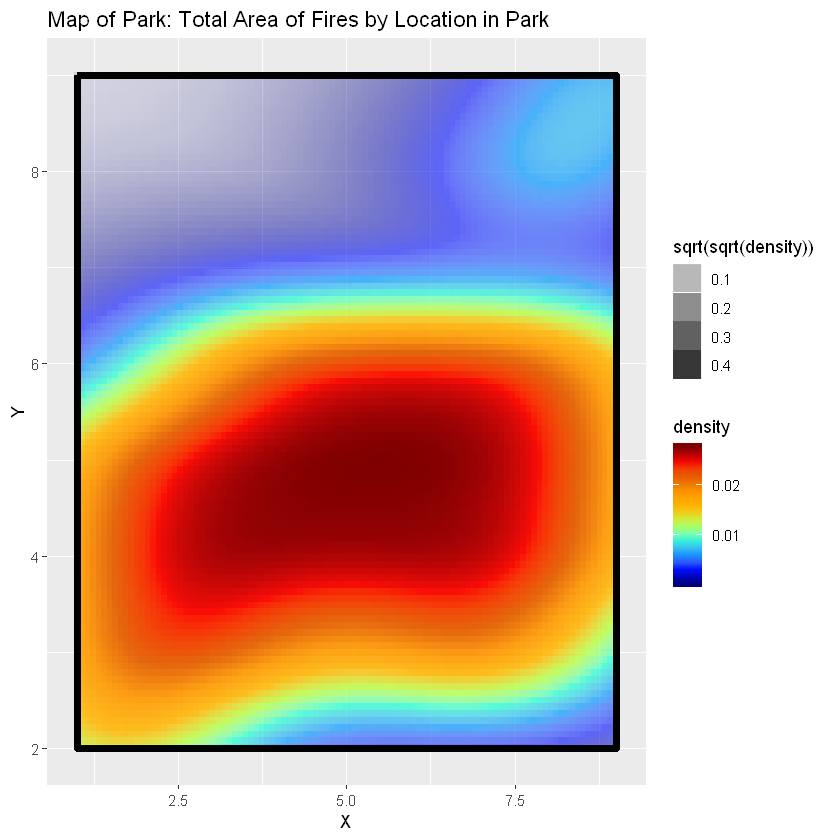

In [8]:
jet.colors <- colorRampPalette(c("#00007F", "blue", "#007FFF", "cyan", "#7FFF7F", "yellow", "#FF7F00", "orange", "#dd4b02", "red", "#7F0000"))

ggplot(ffXYgroup, aes(X, Y, density = totalArea)) + 
  stat_density_2d(geom="tile", aes(fill=..density.., alpha=sqrt(sqrt(..density..))), contour=FALSE, n=100) + 
  scale_alpha(range = c(0.1, 1.0)) + 
  scale_fill_gradientn(colours = jet.colors(10)) + 
  geom_rect(xmin=1, xmax=9, ymin=2, ymax=9, color="black", fill=NA, size=2) + 
  ggtitle("Map of Park: Total Area of Fires by Location in Park")

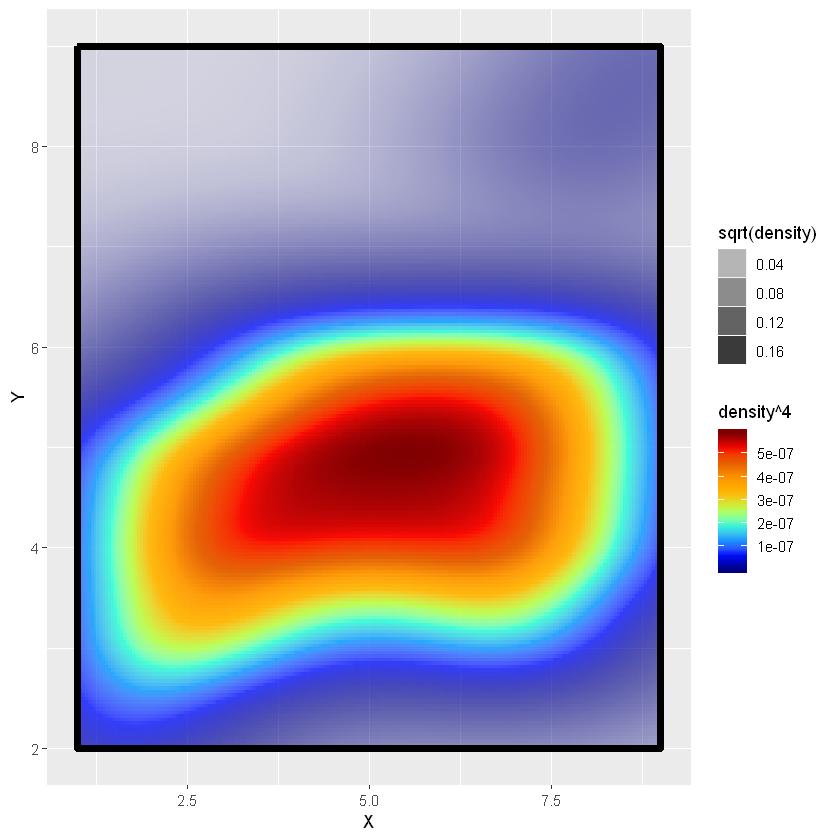

In [344]:
jet.colors <- colorRampPalette(c("#00007F", "blue", "#007FFF", "cyan", "#7FFF7F", "yellow", "#FF7F00", "orange", "#dd4b02", "red", "#7F0000"))

ggplot(ffXYgroup, aes(X, Y, density = logMeanArea)) + 
  stat_density_2d(geom="tile", aes(fill=..density..^4, alpha=sqrt(..density..)), contour=FALSE, n=200) + 
  scale_alpha(range = c(0.1, 1.0)) + 
  scale_fill_gradientn(colours = jet.colors(10)) + 
  geom_rect(xmin=1, xmax=9, ymin=2, ymax=9, color="black", fill=NA, size=2) + 
  ggtitle("Map of Park: Mean Area of Fires by Location in Park")

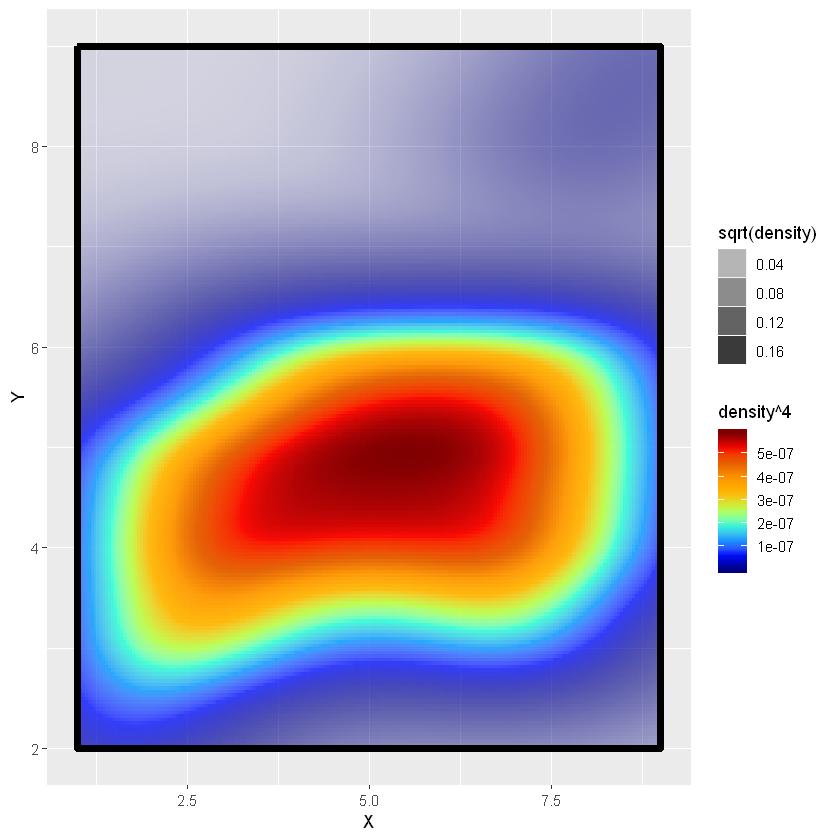

In [345]:
jet.colors <- colorRampPalette(c("#00007F", "blue", "#007FFF", "cyan", "#7FFF7F", "yellow", "#FF7F00", "orange", "#dd4b02", "red", "#7F0000"))

ggplot(ffXYgroup, aes(X, Y, density = count)) + 
  stat_density_2d(geom="tile", aes(fill=..density..^4, alpha=sqrt(..density..)), contour=FALSE, n=200) + 
  scale_alpha(range = c(0.1, 1.0)) + 
  scale_fill_gradientn(colours = jet.colors(10)) + 
  geom_rect(xmin=1, xmax=9, ymin=2, ymax=9, color="black", fill=NA, size=2)

#### Taking a Look at FFMC - FFMC index from the FWI system: 18.7 to 96.20 J
Fine Fuel Moisture Code

In [259]:
summary(ff$FFMC)
sd(ff$FFMC)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  18.70   90.20   91.60   90.64   92.90   96.20 

[1] 5.520111

What we notice from the summary is that the data is fairly compact, it only has a standard deviation of 5.5.  Unfortunately we don't know the units of this variable, but we can tell that most fires occur with a very high FFMC.

In [264]:
summary(bigff$FFMC)
sd(bigff$FFMC)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  63.50   90.35   91.70   90.98   92.90   96.20 

[1] 3.809739

What I see here is that when we remove all of the extremely small fires (less than one hectare), we remove most of the outliers.  This signals to me, that a very low FFMC may indicate a small fire.

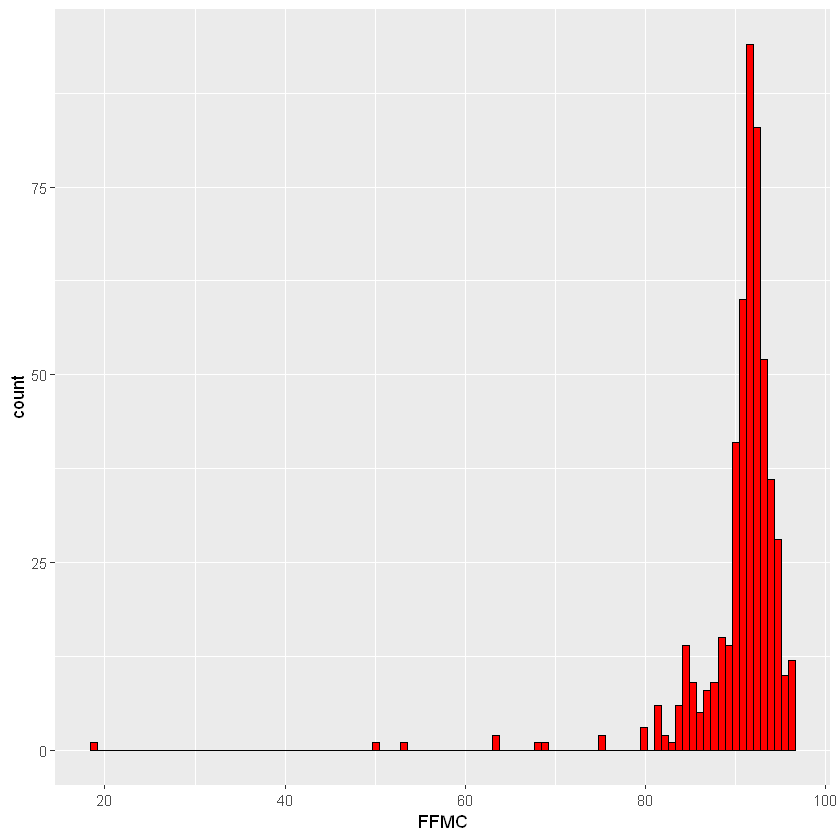

In [273]:
ggplot(ff, aes(x=FFMC)) +
  geom_histogram(bins=100, color="black", fill="red")

I am testing out a different version of the histogram that I think may look better.

Looking at the histogram we confirm what we saw in the summary, the data is very heavily left skewed.  I want to dive into the outliers.

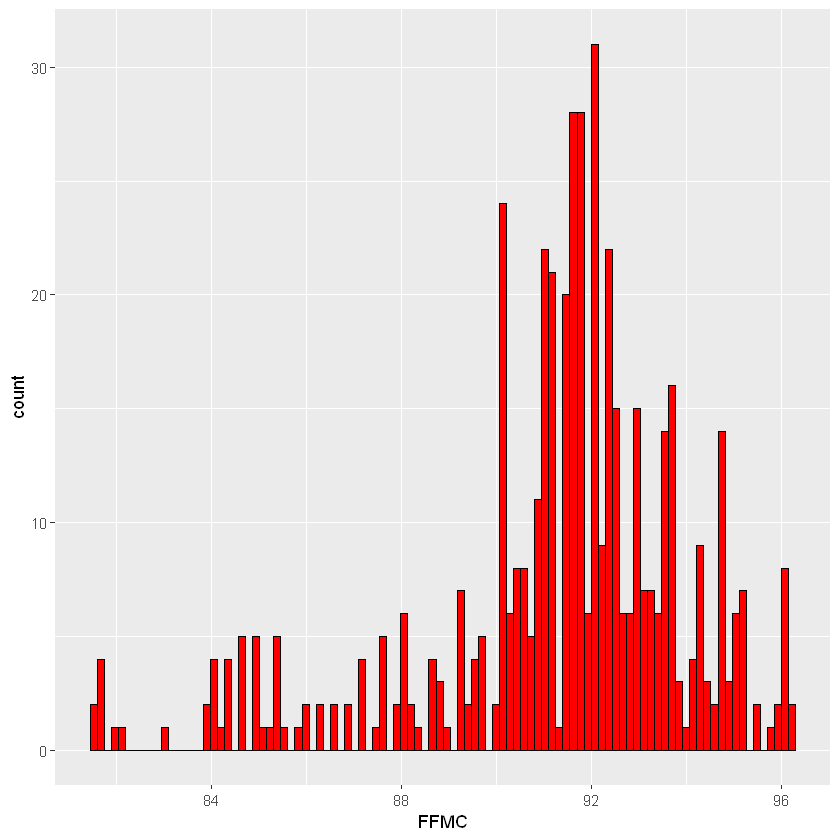

In [283]:
#look at data within 2 std 
ffFFMCusual = ff[ff$FFMC > mean(ff$FFMC) - 2*sd(ff$FFMC) & ff$FFMC < mean(ff$FFMC) + 2*sd(ff$FFMC),]
ggplot(ffFFMCusual, aes(x=FFMC)) +
  geom_histogram(bins=100, color="black", fill="red")

Zooming in on the usual values (within 2 standard deviations) we see that it is still slightly left skewed.

In [288]:
#Looking at the left side outliers
ff[ff$FFMC < mean(ff$FFMC) - 2*sd(ff$FFMC),]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,logArea
13,6,5,aug,fri,63.5,70.8,665.3,0.8,17.0,72,6.7,0,0.00,-Inf
41,4,4,jul,tue,79.5,60.6,366.7,1.5,23.3,37,3.1,0,0.00,-Inf
98,3,4,mar,sat,69.0,2.4,15.5,0.7,17.4,24,5.4,0,0.00,-Inf
131,4,6,feb,sat,68.2,21.5,87.2,0.8,15.4,40,2.7,0,0.00,-Inf
200,2,4,sep,mon,63.5,70.8,665.3,0.8,22.6,38,3.6,0,11.32,2.4265711
300,6,5,jun,sat,53.4,71.0,233.8,0.4,10.6,90,2.7,0,0.00,-Inf
313,2,4,sep,sun,50.4,46.2,706.6,0.4,12.2,78,6.3,0,0.00,-Inf
380,4,5,jan,sun,18.7,1.1,171.4,0.0,5.2,100,0.9,0,0.00,-Inf
464,6,5,feb,tue,75.1,4.4,16.2,1.9,4.6,82,6.3,0,5.39,1.6845454
465,6,4,feb,tue,75.1,4.4,16.2,1.9,5.1,77,5.4,0,2.14,0.7608058


Looking at the breakdown of the low outliers, I look more at the area statistics since that is what we care about.  I notice that the areas are all very small.  The largest fire seen in this group is still below the average fire size of about 12 hectares.

#### DMC - DMC index from the FWI system: 1.1 to 291.3 J
Duff Moisture Code

In [304]:
summary(ff$DMC)
dmcMean = mean(ff$DMC)
dmcSD = sd(ff$DMC)
dmcSD

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.1    68.6   108.3   110.9   142.4   291.3 

[1] 64.04648

First thing I notice is that there is a massive range in these values, from 1.1 to 291.3.  The mean is also at around 1/3 of the total range.

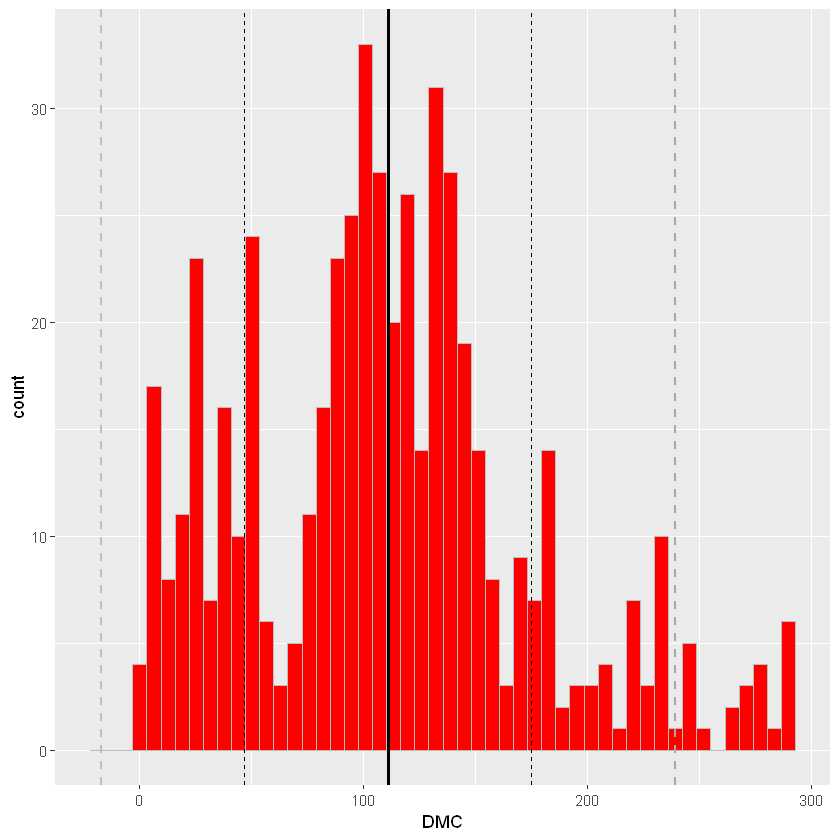

In [321]:
ggplot(ff, aes(x=DMC)) +
  geom_histogram(bins=50, fill="red", color="gray") + 
  geom_vline(aes(xintercept = dmcMean), colour="black", size = 1) + 
  geom_vline(aes(xintercept = dmcMean-dmcSD), colour="black", size = 0.5, linetype="dashed") + 
  geom_vline(aes(xintercept = dmcMean+dmcSD), colour="black", size = 0.5, linetype="dashed") + 
  geom_vline(aes(xintercept = dmcMean-2*dmcSD), colour="gray", size = 0.75, linetype="dashed") + 
  geom_vline(aes(xintercept = dmcMean+2*dmcSD), colour="darkgray", size = 0.75, linetype="dashed")

All things considered this looks like fairly well distributed data.  Yes there is a massive range, but there are no major outliers.  There is a very slight right skew.  Also there is a lot of granularity in the data as it goes down to the tenth.

Next I would like to test with making multiple bin width plots

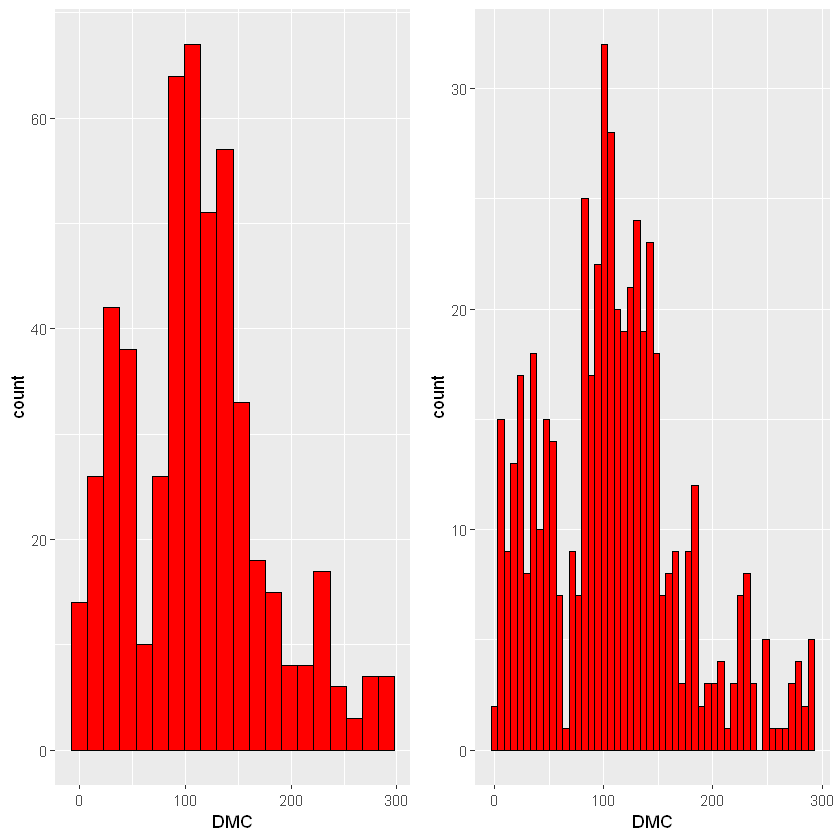

In [296]:
dmc20 = ggplot(ff, aes(x=DMC)) +
  geom_histogram(bins=20, color="black", fill="red")
dmc50 = ggplot(ff, aes(x=DMC)) +
  geom_histogram(bins=50, color="black", fill="red")
grid.arrange(dmc20, dmc50, nrow=1)

#### DC - DC index from the FWI system: 7.9 to 860.6 J
Drought Code

In [299]:
summary(ff$DC)
sd(ff$DC)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    7.9   437.7   664.2   547.9   713.9   860.6 

[1] 248.0662

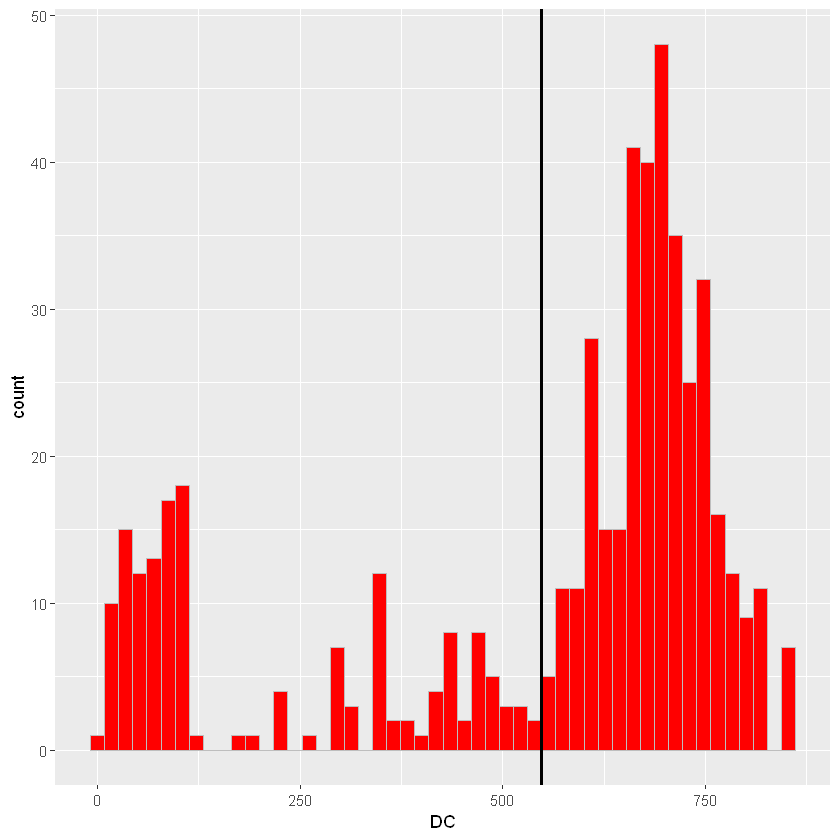

In [323]:
ggplot(ff, aes(x=DC)) +
  geom_histogram(bins=50, color="gray", fill="red") +
  geom_vline(aes(xintercept = mean(ff$DC)), colour="black", size = 1)

Here we notice that the data is fairly bimodal, and has a decently size left skew.  It will be interesting to look into the different types of fires that each clump represents.  Splitting based on the mean could give us a decent grasp of that.  

#### temp - temperature in Celsius degrees: 2.2 to 33.30 J
Seems very normally distributed, should behave well

In [324]:
summary(ff$temp)
tempMean = mean(ff$temp)
tempSD = sd(ff$temp)
tempSD

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.20   15.50   19.30   18.89   22.80   33.30 

[1] 5.806625

Seems like a decent range, although it covers almost every temperature from 100\*F to freezing.  One thing to look at if temperature has a direct effect on fires.

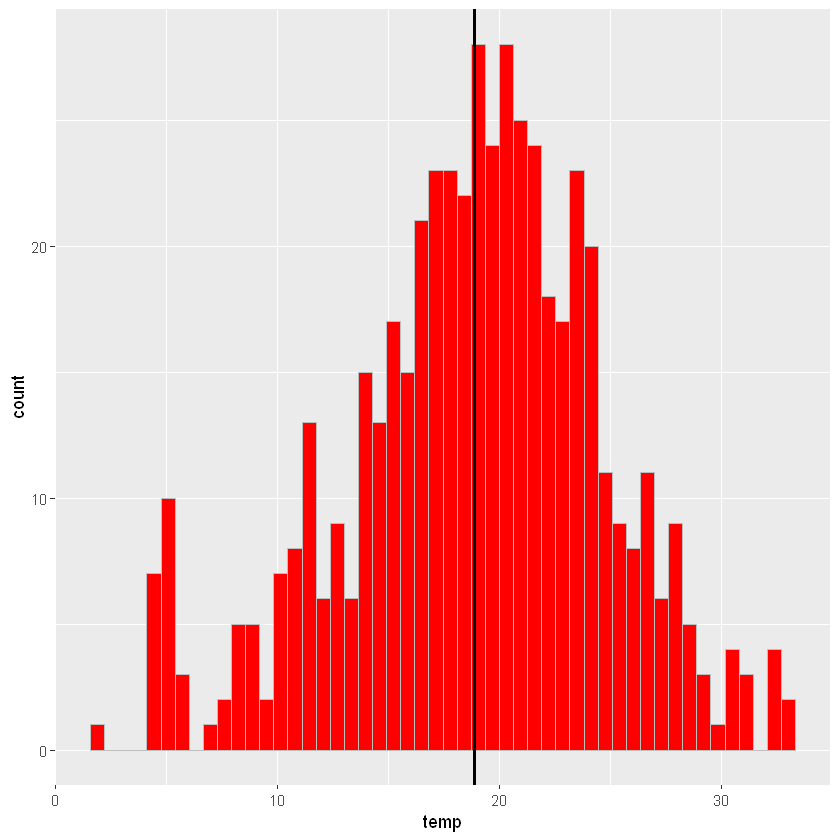

In [325]:
ggplot(ff, aes(x=temp)) +
  geom_histogram(bins=50, color="gray", fill="red") +
  geom_vline(aes(xintercept = tempMean), colour="black", size = 1)

This data is remarkably well distribued, with the average just slightly below room temperature.  I am going to convert it to farenhight to make it slightly easier to understand for us Americans.

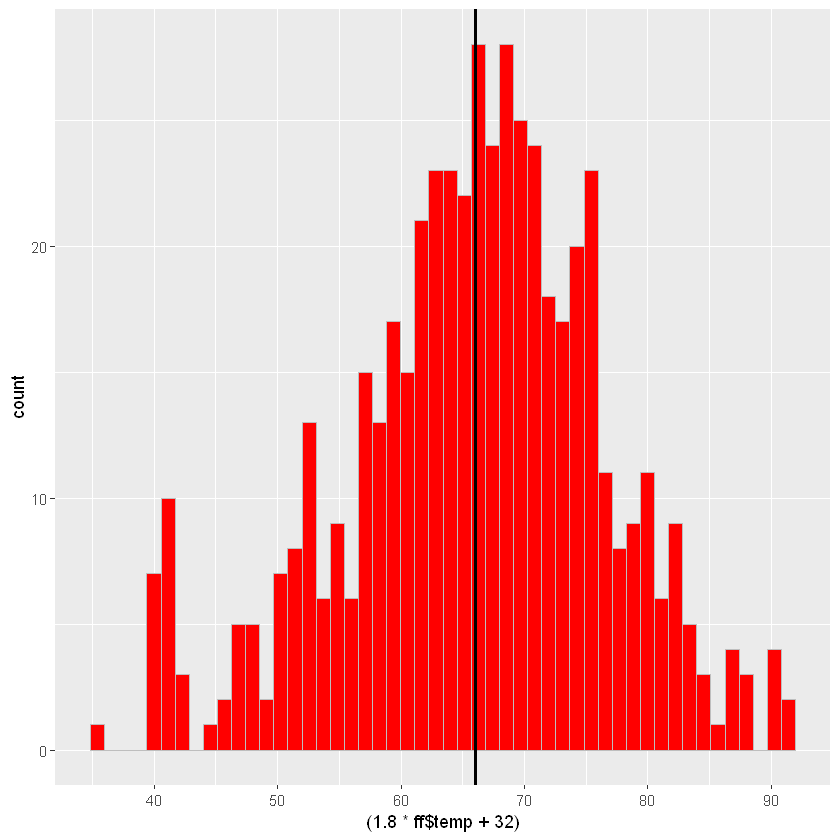

In [328]:
ggplot(ff, aes(x=(1.8*ff$temp +32))) +
  geom_histogram(bins=50, color="gray", fill="red") +
  geom_vline(aes(xintercept = (1.8*tempMean +32)), colour="black", size = 1)

#### ISI - ISI index from the FWI system: 0.0 to 56.10 ?
Initial Spread Index

In [329]:
summary(ff$ISI)
ISIMean = mean(ff$ISI)
ISISD = sd(ff$ISI)
ISISD

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   6.500   8.400   9.022  10.800  56.100 

[1] 4.559477

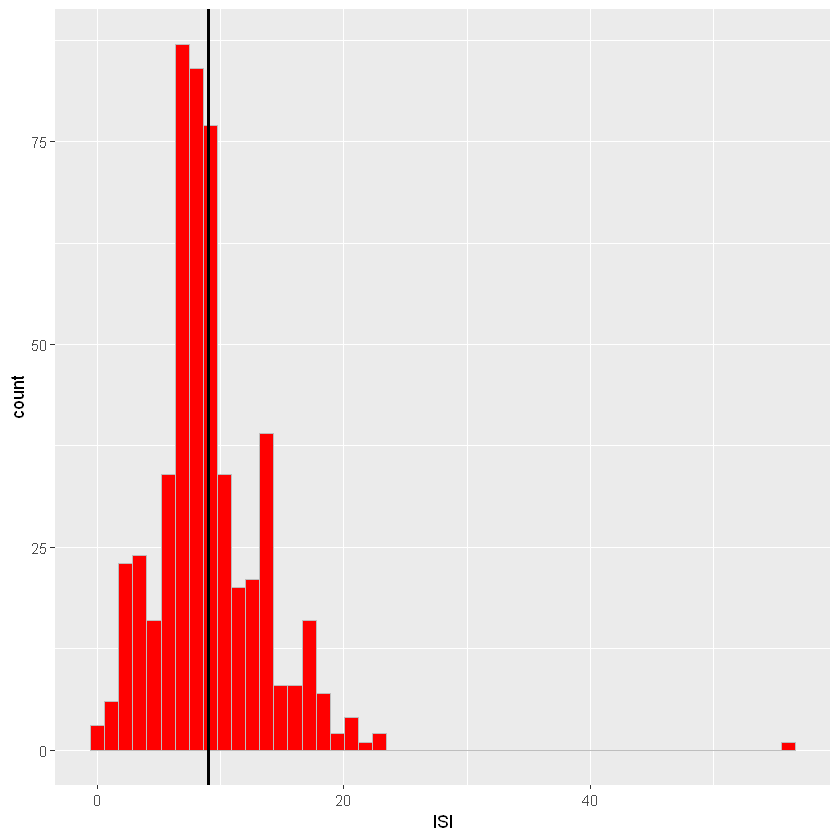

In [330]:
ggplot(ff, aes(x=ISI)) +
  geom_histogram(bins=50, color="gray", fill="red") +
  geom_vline(aes(xintercept = ISIMean), colour="black", size = 1)

ISI seems to behave very well, except for one very high outlier.  I want to take a look at it.

In [331]:
ff[ff$ISI > 30,]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,logArea
23,7,4,jun,sun,94.3,96.3,200,56.1,21,44,4.5,0,0,-Inf


There doesn't seem to be too much odd about this data point.  The FFMC, DMC, and DC are in normal limits.  The temp is barely elevated.  The area is marked as 0 as well.  The only thing remarkable about this point is the extremely high ISI.  If I understand the Initial Spread Index correctly, this was a fire that spread extremely rapidly, but was put out before it grew at all.  

In [333]:
ff[order(ff$ISI)[1:10],]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,logArea
380,4,5,jan,sun,18.7,1.1,171.4,0.0,5.2,100,0.9,0,0.00,-Inf
300,6,5,jun,sat,53.4,71.0,233.8,0.4,10.6,90,2.7,0,0.00,-Inf
313,2,4,sep,sun,50.4,46.2,706.6,0.4,12.2,78,6.3,0,0.00,-Inf
98,3,4,mar,sat,69.0,2.4,15.5,0.7,17.4,24,5.4,0,0.00,-Inf
13,6,5,aug,fri,63.5,70.8,665.3,0.8,17.0,72,6.7,0,0.00,-Inf
131,4,6,feb,sat,68.2,21.5,87.2,0.8,15.4,40,2.7,0,0.00,-Inf
200,2,4,sep,mon,63.5,70.8,665.3,0.8,22.6,38,3.6,0,11.32,2.426571
517,6,3,nov,tue,79.5,3.0,106.7,1.1,11.8,31,4.5,0,0.00,-Inf
41,4,4,jul,tue,79.5,60.6,366.7,1.5,23.3,37,3.1,0,0.00,-Inf
466,2,2,feb,sat,79.5,3.6,15.3,1.8,4.6,59,0.9,0,6.84,1.922788


Here are the 10 smallest ISI fires.  They don't appear to have much in common.  DMC and DC appear to be all over the place.  I do see that they tend to have lower temperatures, and be on the low end of the FFMC scale.  They also have a disproportionate grouping of 0 area fires.

#### Comparing all of the variables together

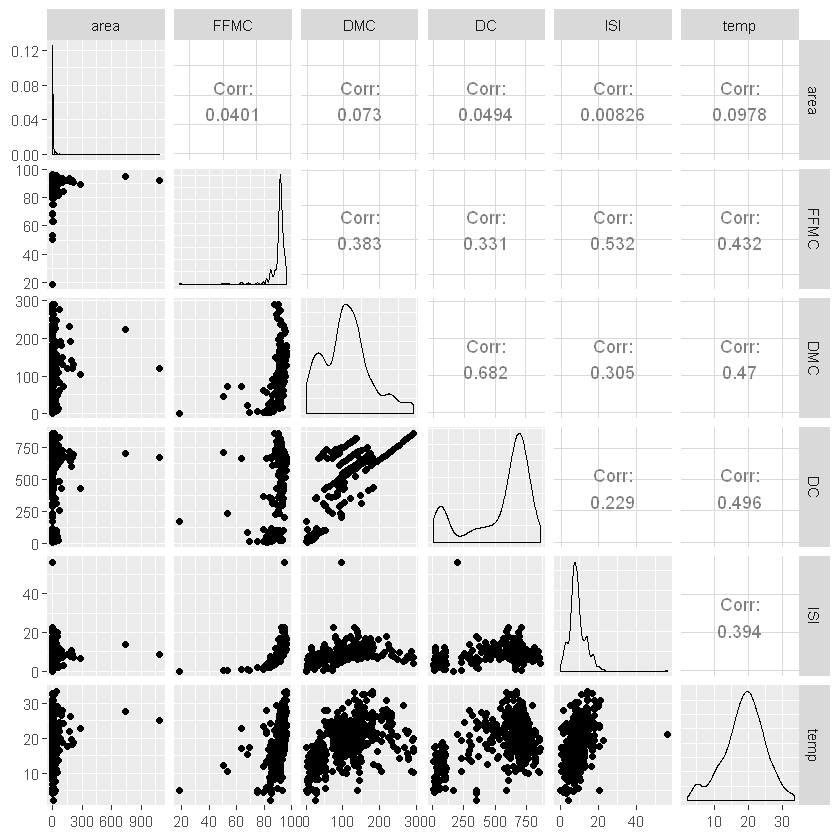

In [336]:
ggpairs(ff[,c('area', 'FFMC', 'DMC', 'DC', 'ISI', 'temp')])

Warning message:
"Removed 10857 rows containing non-finite values (stat_smooth)."

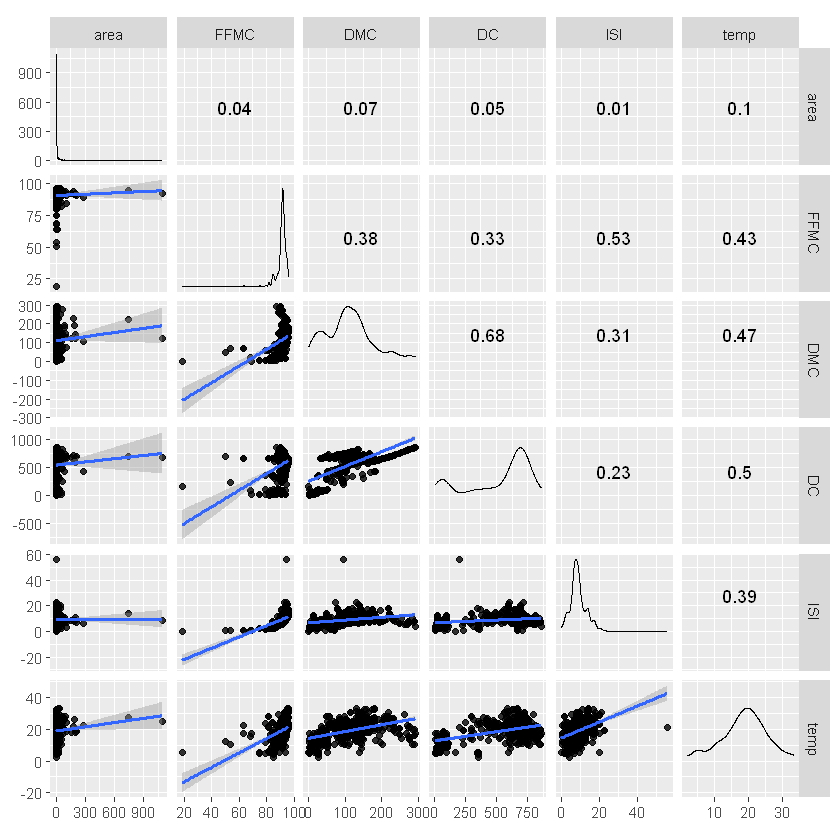

In [19]:
ggscatmat(ff[,c('area', 'FFMC', 'DMC', 'DC', 'ISI', 'temp')], alpha=0.8) +
geom_smooth(method="lm")

There is a lot of colinearity in these variables.  The highest correlation between any of the variables is between DC and DMC, with a 0.68.  This means that our secondary effects write up will be full of interactions between FFMC, DMC, DC, ISI, and Temp.  They are all extremely related to each other.  

In [8]:
#big fires
bff = ff[ff$area>10,]
#severe fires
sff = ff[ff$area>50,]

Warning message:
"Removed 2660 rows containing non-finite values (stat_smooth)."

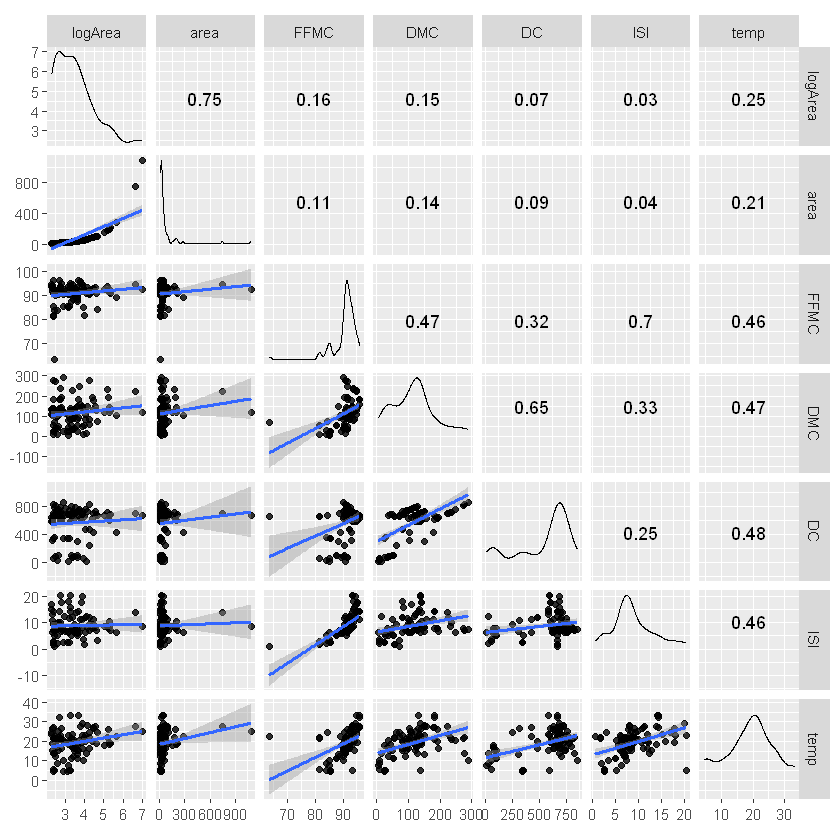

In [17]:
ggscatmat(bff[,c('logArea', 'area', 'FFMC', 'DMC', 'DC', 'ISI', 'temp')], alpha=0.8) +
geom_smooth(method="lm")

Warning message:
"Removed 672 rows containing non-finite values (stat_smooth)."

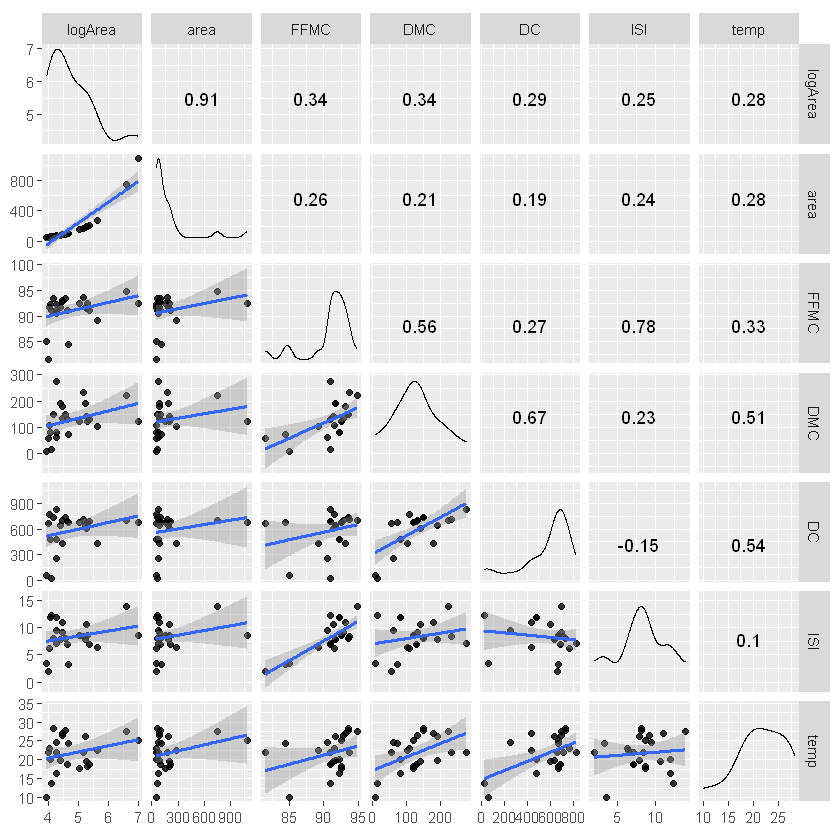

In [16]:
ggscatmat(sff[,c('logArea', 'area', 'FFMC', 'DMC', 'DC', 'ISI', 'temp')], alpha=0.8) +
geom_smooth(method="lm")

Looking at only the severe fires we can see that the correlation between each variable and the severity (area) become much more pronounced, up to a 0.28 between temp and area.

Warning message:
"Removed 280 rows containing non-finite values (stat_smooth)."

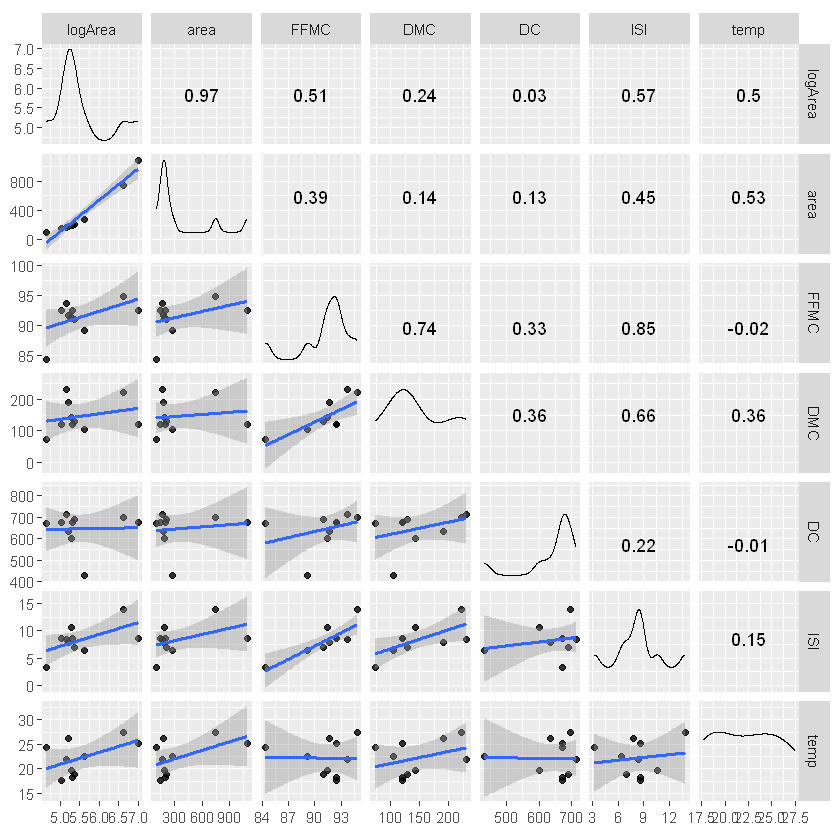

In [15]:
ggscatmat(sff[order(sff$area, decreasing=T)[1:10],c('logArea', 'area', 'FFMC', 'DMC', 'DC', 'ISI', 'temp')], alpha=0.8) +
geom_smooth(method="lm")

These correlations get even stronger as we are looking at the most damaging fires.  The top 10 fires in the park.  Temperature and area are extremely correlated.

Could visualize temperatures effect by making a stacked histogram of area, colorized by average temperature?